<a href="https://colab.research.google.com/github/HereisYiran/InversePlanningCopy/blob/main/tutorials/inv_plan_from_scratch/inv_plan_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inverse Planning from Scratch

This tutorial explains how to use probabilistic programming to implement
inverse planning for a simple gridworld agent. By modeling the agent as
an *approximately rational planner* who takes efficient actions towards
a goal, then inverting this generative process, inverse planning allows us
to infer the agent's goal from their observed actions.

We will see how to do this "from scratch", in the sense that we won't be using
existing library code for planning or inverse planning. Instead we will
implement everything using [Gen.jl](https://github.com/probcomp/Gen.jl), a
general-purpose probabilistic programming framework that allows us to write
generative models and inference algorithms with minimal math.

Specifically, we will cover the following material:
 - Modeling agents with probabilistic programs
 - Simulating and visualizing our agent model
 - Inferring goals via inverse planning
 - Online inverse planning via incremental computation

Below we install the necessary packages:

In [ ]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.add(["Gen", "GLMakie", "FileIO", "HTMLVideoPreview"])

## Modeling agents with probabilistic programs

Inverse planning treats goal inference — and the inference of mental states
more generally — as an inverse problem: Given a generative model of an agent's
goal-directed actions (that is, a model where agent's actions are generated
conditional on a latent goal), we want to invert the model, inferring the goal
from the actions we observe.

What does this model look like? At a high level, the model should specify:
- $P(g)$, a prior distribution over possible goals $g$ (*Goal Prior*)
- $P(a_t | s_t, g)$, a model of how the agent takes an action $a_t$ given
  their goal $g$ and the current environment state $s_t$ (*Action Policy*)
- $P(s_{t+1} | s_t, a_t)$, a model of how the environment changes in
  response to the agent's action $a_t$ (*Environment Dynamics*)

Together, these components define a joint distribution over the agent's goal,
actions, and environment states up to any timestep $T$:

$$
P(g, a_{1:T}, s_{1:T}) = P(g_1) \prod_{t=1}^T P(a_t | s_t, g) P(s_{t+1} | s_t, a_t)
$$

In this tutorial, we'll start with a simple goal prior $P(g)$ that is
uniform over a set of possible goals $\mathcal{G}$. For the environment
dynamics $P(s_{t+1} | s_t, a_t)$, we'll model a deterministic gridworld
where the agent's location changes based on their action (i.e. if the **up**
action is taken, the agent moves up unless there is an obstacle in the way).

But what about the action policy $P(a_t | s_t, g)$? A key assumption in
inverse planning is that agents are *approximately rational*. In particular,
agents are more likely to take actions that lead them efficiently towards
their goals. To capture this assumption, we'll model the agent as following
a *Boltzmann-rational policy*:

$$
P(a_t | s_t, g) = \frac{\exp(\beta \cdot Q_g(s_t, a_t))}{\sum_{a' \in A(s_t)} \exp(\beta \cdot Q_g(s_t, a'))}
$$

Here, $Q_g(s_t, a_t)$ is the expected utility of taking action $a_t$ at
state $s_t$ when the agent's goal is $g$, also known as the *Q-value*.
The parameter $\beta$ is called the *inverse temperature* or
*rationality coefficient*, and controls how optimal (vs. random) the agent is.
When $\beta$ is higher, the policy assigns higher probabilities to actions
with higher expected utilities. $A(s_t)$ is the set of possible actions
at state $s_t$.

### Writing an agent model probabilistic program

We can now specify our generative model of an agent as a probabilistic program,
which includes each of the components described above (setting aside for now
how Q-values are computed):

In [ ]:
using Gen
using Gen.Distributions: softmax

"Uniform distribution over a list of labels."
@dist labeled_uniform(labels) = labels[uniform_discrete(1, length(labels))]

"Categorical distribution over a list of labels."
@dist labeled_categorical(labels, probs) = labels[categorical(probs)]

"Return the next gridworld environment state given the current state and action."
function gridworld_env_step(grid, loc, act)
    # Return next location if in-bounds and not a wall
    next_loc = loc .+ act
    if checkbounds(Bool, grid, next_loc...) && !grid[next_loc...]
        return next_loc
    else
        return loc
    end
end

"Boltzmann-rational agent model in a gridworld environment."
@gen function gridworld_agent_model(T, grid, init_loc, goal_locs, beta)
    # Sample goal from uniform goal prior P(g)
    goal = {:goal} ~ labeled_uniform(goal_locs)
    loc = init_loc
    loc_history = [loc]
    act_history = Tuple{Int, Int}[]
    # Iterate over timesteps
    for t in 1:T
        # Compute Q-values and Boltzmann action probabilities
        actions, q_values = compute_q_values(grid, loc, goal)
        act_probs = softmax(beta .* q_values)
        # Sample action according to Boltzmann policy P(a_t | s_t, g)
        act = {(:act, t)} ~ labeled_categorical(actions, act_probs)
        # Update location following environment dynamics P(s_{t+1} | s_t, a_t)
        loc = gridworld_env_step(grid, loc, act)
        push!(loc_history, loc)
        push!(act_history, act)
    end
    return goal, loc_history, act_history
end;

Probabilistic programs are programs that make random choices during their
execution, allowing us to specify generative models as code. When using
Gen.jl, probabilistic programs look almost exactly like regular Julia functions,
except they are annotated with the `@gen` macro at the start, and make random
choices using the `~` operator. The `gridworld_agent_model` above makes random
choices at two places: first, when sampling a goal $g$ frm a uniform prior
$P(g)$ over goals:

```julia
goal = {:goal} ~ labeled_uniform(goal_locs)
```

and second, when sampling an action $a_t$ from a Boltzmann-rational policy
$P(a_t | s_t, g)$:

```julia
act = {(:act, t)} ~ labeled_categorical(actions, act_probs)
```

Each of these random choices is associated with an *address*, which gives a
unique name to the random variable being sampled. The result of the random
choice can optionally be assigned to regular Julia variable. For example, when
sampling the agent's action at step `t` of the for-loop, the sampled action
is given the address `(:act, t)`, and is assigned to the local variable `act`.

### Computing Q-values via planning

To complete our probabilistic program, we need to specify how to compute the
Q-values of each action via the `compute_q_values` function. To do this, let's
first think about what $Q_g(s_t, a_t)$ represents: What is the expected utility
of taking action $a_t$ at state $s_t$ when the agent's goal is $g$?

In our simple gridworld, we assume that the agent wants to reach their goal $g$
while minimizing the cost of the actions it takes to get there. So the expected
utility of taking action $a_t$ is just the (negative) cost of action $a_t$
itself, plus the expected utility of reaching $g$ from the next state $s_{t+1}$
(denoted $V_g(s_{t+1})$). Recursively, we define $V_g(s_t)$ — also known as the
*value function* or *cost-to-go function* — as the maximum expected utility
(i.e. minimum expected cumulative cost) of taking any action from state $s_t$:

$$
\begin{align*}
Q_g(s_t, a_t) &= -C(a_t) + V_g(s_{t+1}) \\
V_g(s_t) &= \max_a Q_g(s_t, a)
\end{align*}
$$

Let's assume that cost of any action $C(a_t)$ is 1. Together with the fact that
our environment is deterministic, these definitions imply that $V_g(s_t)$ is
just the *length of the shortest path* from $s_t$ to $g$ (but negated).
Correspondingly, $Q_g(s_t, a_t)$ is the length of the shortest path from $s_t$
to $g$ that involves first taking action $a_t$. This means we can compute
$Q_g(s_t, a_t)$ for each action $a_t$ via a path planning algorithm. In our
simple gridworld, it is enough to use [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).

In [ ]:
"Compute Q-values for each action given the current location and goal location."
function compute_q_values(grid, loc, goal)
    # Define list of possible actions (stay, up, down, left, right)
    actions = ((0, 0), (-1, 0), (1, 0), (0, -1), (0, 1))
    # Compute shortest path from each successor location to goal
    q_values = zeros(length(actions))
    for i in 1:length(actions)
        next_loc = loc .+ actions[i]
        if checkbounds(Bool, grid, next_loc...) && !grid[next_loc...]
            # Run Dijkstra's algorithm from next_loc to goal
            q_values[i] = -shortest_path_length(grid, next_loc, goal) - 1
        else
            # Negative infinite Q-value if next_loc is unreachable
            q_values[i] = -Inf
        end
    end
    return actions, q_values
end

"Compute the shortest path length from start to goal via Dijkstra's algorithm."
function shortest_path_length(grid, start, goal)
    # Initialize distances to infinity
    distances = fill(Inf, size(grid))
    distances[start...] = 0.0
    # Initialize priority queue (FIFO is enough since action costs are equal)
    queue = [(0.0, start)]
    while !isempty(queue)
        dist, loc = popfirst!(queue)
        if loc == goal
            return dist
        end
        for d in ((-1, 0), (1, 0), (0, -1), (0, 1))
            next_loc = loc .+ d
            if checkbounds(Bool, grid, next_loc...) && !grid[next_loc...]
                alt = dist + 1.0
                if alt < distances[next_loc...]
                    distances[next_loc...] = alt
                    push!(queue, (alt, next_loc))
                end
            end
        end
    end
    return Inf
end;

**Question**: The approach above is not the most efficient way of computing
Q-values, since it requires invoking Dijkstra's algorithm for each action.
Can you think of an approach that requires invoking Dijkstra's algorithm only
once for all actions?

**Question**: Dijkstra's algorithm can be a reasonable way to compute Q-values
for small deterministic environments. Do you think it can be applied to
stochastic environments? What about environments where it is very diffult to
find a path to the goal via breadth-first exploration?

## Simulating and visualizing our agent model

With our model fully defined, we can now run `gridworld_agent_model` with
specific arguments to generate a possible trajectory for our agent.

In [ ]:
grid = BitMatrix([ # 2D grid where 1s are walls
    0 0 0 0 0
    0 1 1 0 1
    0 0 0 0 0
    0 1 0 1 0
    0 1 0 1 0
])
init_loc = (5, 3) # Initial location at row 5, column 3
goal_locs = ((1, 2), (1, 5), (5, 1)) # 3 possible goal locations
beta = 10.0 # Assume the agent is highly optimal
T = 10 # Run the model for 10 timesteps
goal, loc_history, act_history =
    gridworld_agent_model(T, grid, init_loc, goal_locs, beta)
@show goal;
@show loc_history;

goal = (1, 5)
loc_history = [(5, 3), (4, 3), (3, 3), (3, 4), (2, 4), (1, 4), (1, 5), (1, 5), (1, 5), (1, 5), (1, 5)]


As you can see, the agent starts from its initial location, then navigates the
gridworld towards one of the three possible goals. The path the agent takes is
highly optimal, due to `beta` being set to a high value. Once the agent reaches
the goal, it stays in place.

### Generating traces of probabilistic programs

A key benefit of writing our model in a probabilistic programming language is
that we can do more than just simulate executions of our model and collect
their return values (as shown above). We can also *evaluate* the probability of
a specific simulation, and run *constrained* simulations, where certain random
variables are fixed to specific values. This can be done with the following
functions:

In [ ]:
# Simulate an execution trace from our agent model
model_args = (5, grid, init_loc, goal_locs, 2.0)
trace = Gen.simulate(gridworld_agent_model, model_args)
show(stdout, "text/plain", get_choices(trace)) # Show the choices in this trace

# Evaluate the log-probability (a.k.a. score) of the sampled trace
logprob = Gen.get_score(trace)
@show logprob;

# Generate a trace with the goal constrained to a specific value
goal_constraint = choicemap((:goal, (1, 2)))
trace, weight = Gen.generate(gridworld_agent_model, model_args, goal_constraint)
println("\n", "Traced choices given constrained goal:")
show(stdout, "text/plain", get_choices(trace)) # Goal is fixed, other choices are sampled
@show weight; # Log-prob. of constrained choices given ancestors (= log P(g))

# Generate trace with actions constrained to observed values
act_constraints = choicemap(
    ((:act, 1), (-1, 0)), ((:act, 2), (-1, 0)), ((:act, 3), (0, 1)),
    ((:act, 4), (-1, 0)), ((:act, 5), (-1, 0))
)
trace, weight = Gen.generate(gridworld_agent_model, model_args, act_constraints)
println("\n", "Traced choices given constrained actions:")
show(stdout, "text/plain", get_choices(trace))  # Actions are fixed, other choices are sampled
@show weight; # Log-prob. of constrained choices given ancestors (= log P(a_{1:T} | g))

│
├── (:act, 1) : (-1, 0)
│
├── (:act, 4) : (0, 0)
│
├── (:act, 3) : (0, -1)
│
├── (:act, 2) : (-1, 0)
│
├── :goal : (1, 2)
│
└── (:act, 5) : (0, -1)
logprob = -4.421499690517151

Traced choices given constrained goal:
│
├── (:act, 1) : (0, 0)
│
├── (:act, 4) : (-1, 0)
│
├── (:act, 3) : (-1, 0)
│
├── (:act, 2) : (0, 0)
│
├── :goal : (1, 2)
│
└── (:act, 5) : (0, 1)
weight = -1.0986122886681098

Traced choices given constrained actions:
│
├── (:act, 1) : (-1, 0)
│
├── (:act, 4) : (-1, 0)
│
├── (:act, 3) : (0, 1)
│
├── (:act, 2) : (-1, 0)
│
├── :goal : (1, 2)
│
└── (:act, 5) : (-1, 0)
weight = -1.3386389325389783


The `simulate`, `get_score`, and `generate` functions are basic primitives that
can be used to implement a wide variety of inference algorithms (MCMC,
particle filtering, etc.). All of them operate over **traces**: a representation
of an execution trace of a probabilistic program, which records all the random
choices sampled along the way (exposed by `get_choices`), and also the joint
probability of those choices (exposed by `get_score`).

Most users of Gen can make use of higher-level interfaces that call these
functions under-the-hood, but being familiar with concept of a trace is crucial
to using Gen. We'll also see later how the `Gen.generate` function can be used
to implement an inference algorithm via constrained generation and weighting
of traces.

### Visually inspecting our model

While it is possible work with and inspect traces entirely in code, it is good
practice to visualize our model and the traces it generates. Visualization
can surface modeling errors that are otherwise hard to notice, whether at the
level of individual traces, or in terms of the overall distribution of traces
sampled from the model. Below we provide code to visualize our agent model
using the [Makie](https://docs.makie.org/stable/) plotting libary.

In [ ]:
using GLMakie, Printf
using Downloads, FileIO
using HTMLVideoPreview

GLMakie.activate!(scalefactor=1.0)
Makie.inline!(true)

AGENT_IMG_URL = "https://gist.githubusercontent.com/ztangent/9472b4888d3b6a3ca3232d9d841b6169/raw/human.png"
AGENT_IMG = rotr90(FileIO.load(Downloads.download(AGENT_IMG_URL)))
GOAL_COLORS = [
    colorant"#D41159", colorant"#FFC20A", colorant"#1A85FF", colorant"#007D68",
    colorant"#785EF0", colorant"#D55E00", colorant"#56B4E9", colorant"#CC79A7"
]

"Render a trace of the gridworld agent model to an existing axis."
function render_trace!(ax, trace::Union{Trace, Observable}, t = nothing)
    # Wrap trace in Observable to enable interactive plotting
    trace = trace isa Observable ? trace : Observable(trace)
    t_obs = isnothing(t) ?
        @lift(Gen.get_args($trace)[1]) :
        t isa Observable ? t : Observable(t)
    # Plot heatmap showing grid
    grid_obs = @lift reverse(transpose(Gen.get_args($trace)[2]), dims=2)
    cmap = cgrad([:transparent, :black])
    heatmap!(ax, grid_obs, colormap=cmap, colorrange=(0, 1))
    hidedecorations!(ax, grid=false)
    map!(h -> (1:h-1) .+ 0.5, ax.yticks, @lift(size($grid_obs)[1]))
    map!(w -> (1:w-1) .+ 0.5, ax.xticks, @lift(size($grid_obs)[2]))
    # Render goal locations
    goal_locs_obs = Observable([(1, 1)])
    goal_colors = Observable(GOAL_COLORS[1:1])
    scatter!(ax, goal_locs_obs, color=goal_colors, marker='♦',
             markerspace=:data, markersize=1.0)
    # Render agent trajectory
    loc_history_obs = Observable([(1, 1)])
    scatter!(ax, loc_history_obs, color=:black, marker='⦿',
             markerspace=:data, markersize=0.4)
    # Render current agent location
    agent_x_bounds_obs = Observable((0.5, 1.5))
    agent_y_bounds_obs = Observable((0.5, 1.5))
    image!(ax, agent_x_bounds_obs, agent_y_bounds_obs, AGENT_IMG)
    # Update observables with values from trace
    onany(trace, t_obs) do trace, t
        # Extract argument and return values
        T, grid, init_loc, goal_locs, beta = Gen.get_args(trace)
        retvals = Gen.get_retval(trace)
        if length(retvals) == 2 # Handle Unfold-model variants
            goal, model_states = retvals
            loc_history = [s.loc for s in model_states]
            pushfirst!(loc_history, init_loc)
        else
            goal, loc_history, act_history = retvals
        end
        h, w = size(grid)
        # Clamp rendered timestep to [0, T]
        t = max(0, min(T, t))
        # Update goal locations
        empty!(goal_locs_obs[])
        append!(goal_locs_obs[], [(x, h-y+1) for (y, x) in goal_locs])
        empty!(goal_colors[])
        append!(goal_colors[], GOAL_COLORS[1:length(goal_locs)])
        notify(goal_locs_obs)
        notify(goal_colors)
        # Update location history (flipping y and x coordinates)
        empty!(loc_history_obs[])
        append!(loc_history_obs[], [(x, h-y+1) for (y, x) in loc_history[1:t+1]])
        notify(loc_history_obs)
        # Update agent location bounds
        cur_loc = loc_history[t+1]
        agent_x_bounds_obs[] = (cur_loc[2] - 0.5, cur_loc[2] + 0.5)
        agent_y_bounds_obs[] = (h - cur_loc[1] + 0.5, h - cur_loc[1] + 1.5)
    end
    notify(trace)
    return ax
end

"Render a trace of the gridworld agent model to a new figure."
function render_trace(trace::Union{Trace, Observable}, t = nothing;
                      size = (512, 512))
    figure = Figure(size=size)
    ax = Axis(figure[1, 1], aspect=DataAspect())
    render_trace!(ax, trace, t)
    return figure
end

"Animate a trace of the gridworld agent model over time."
function anim_trace(trace; size = (512, 512), kwargs...)
    T = trace isa Observable ? Gen.get_args(trace[])[1] : Gen.get_args(trace)[1]
    t_obs = Observable(0)
    figure = render_trace(trace, t_obs; size=size)
    recording = Record(figure, 0:T; kwargs...) do t
        t_obs[] = t
    end
    format = recording.options.format
    path = FileIO.save(tempname() * "." * format, recording)
    return videopreview(path)
end

"Render a collection of traces as a grid of subplots in a new figure."
function render_traces(
    traces::AbstractVector, ts = nothing;
    n_rows = ceil(Int, sqrt(length(traces))),
    n_cols = ceil(Int, length(traces) / n_rows),
    size = (192 * n_cols, 192 * n_rows)
)
    figure = Figure(size=size)
    for n in 1:length(traces)
        i = div(n - 1, n_cols) + 1
        j = mod(n - 1, n_cols) + 1
        ax = Axis(figure[i, j], aspect=DataAspect())
        t = ts isa AbstractArray ? ts[n] : ts
        render_trace!(ax, traces[n], t)
    end
    return figure
end

"Animate a collection of traces over time."
function anim_traces(
    traces::AbstractVector;
    n_rows = ceil(Int, sqrt(length(traces))),
    n_cols = ceil(Int, length(traces) / n_rows),
    size = (192 * n_cols, 192 * n_rows),
    kwargs...
)
    T = maximum(traces) do trace
        trace isa Observable ? Gen.get_args(trace[])[1] : Gen.get_args(trace)[1]
    end
    t_obs = Observable(0)
    figure = render_traces(traces, t_obs; n_rows, n_cols, size)
    recording = Record(figure, 0:T; kwargs...) do t
        t_obs[] = t
    end
    format = recording.options.format
    path = FileIO.save(tempname() * "." * format, recording)
    return videopreview(path)
end;

Using this code, we can now visualize a single trace from our model:

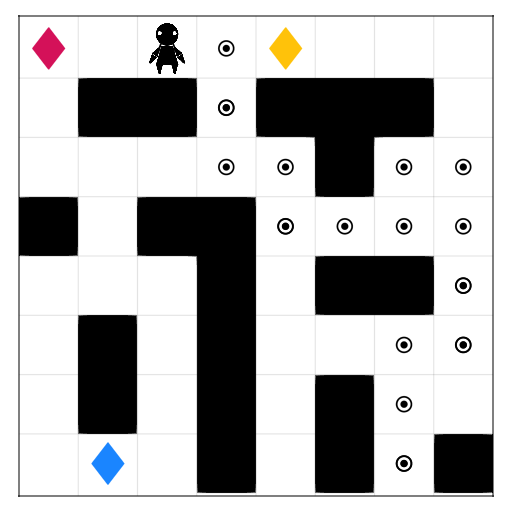

In [ ]:
# Specify arguments
grid = BitMatrix([ # 2D grid where 1s are walls
    0 0 0 0 0 0 0 0
    0 1 1 0 1 1 1 0
    0 0 0 0 0 1 0 0
    1 0 1 1 0 0 0 0
    0 0 0 1 0 1 1 0
    0 1 0 1 0 0 0 0
    0 1 0 1 0 1 0 0
    0 0 0 1 0 1 0 1
])
init_loc = (8, 7) # Initial location at row 5, column 3
goal_locs = ((1, 1), (1, 5), (8, 2)) # 3 possible goal locations
beta = 1.0 # Assume the agent is noisily rational
T = 20 # Run the model for 20 timesteps
model_args = (T, grid, init_loc, goal_locs, beta)

# Simulate trace
trace = Gen.simulate(gridworld_agent_model, model_args)

# Visualize trace
render_trace(trace)

We can also animate the trace over time (this allows us to more easily see
actions when the agent randomly backtracks):

In [ ]:
anim = anim_trace(trace, framerate=3, format="mp4")

VideoPreview("AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAVvhtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MyBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAFypliIQAFP/+99S3zLLtUzI/+R/5fqAWbTamwBjLtS0G7ChB9RdAq/l45zTWk1Z9/5dfJjL0pHJS3qQShrG4mwAAAwAAAwAcctN+o6nDT/6GGt//QTCemfo2No9/uVeJ+XdbHKMzQr79xo3V9bCt6srBTLiiPKOq9vd+cftAhVV0eExSaIWCpf4njPHel6wlUXhbBUbaqnrrWASFDEPbZJkO9f21X0YeKRgCjPbZTM1yKHMnOjtBs6O+8fbgOpjcHlZK+hMyPOfZKh/LvZaROK++bUe0lsv6VYThgO6QWVSAHJzoQ3TrbN0g55ovFUPL5qK0uO3dl5kDZYbrIWcYtz1jrecHxLt9INtegHOGB0x91zeR2PuQViczIRAGEiqxUs7bM1vbMa/4bru7WlVOlTXruR4QdDcsSl1DR5JWU+MFBYJoLGlvje5x9qpBNnfiD5PqV+rW3aLvtdY+SHlFRzZo3JamI50n7Yqrv67RFslxF+9T+GdCMQgD/z+V16MXpXUvQ/CzFCpZ9vJ1bVu25XwkHcN2MxeMYimlAbkLxrJVcKN3Gc/yA/koZQzAvUWhmp0RaY2Ocqbzf/9OA45lMuI4fcg2f5lVzzwk/4OgdfQgDHumPo4Sd6dkrnYxca6aDRSd2/vELgNJxg3s9l1t3sCxO52AF4vJGwUBqTLiifBIM++yfPSjnAQPVQy1JR89nLh0MORuLO0R0BXsM1Rwe/l371rBwurm/DRjLp1dn3Fq573zEBpkmT20MoZHBnzCpo0b0QNKsVsxSKX3E4GIjCZBMOemWqddQC3ub0cd2SsD1IKmOa71xnFPEKTGXp8Q5HjVoJUagOjpePYh/Q5YMgQE8fbFZj1EM6Rvio4cCC1a2cyNREBQEHzS6cAl7Bs7DbWmUzM30HdQ/+vi97ToI/eFFv3PCEx50u2cRLjKAKcliWCp4g8EG3Rz9gmpBcXb2LnC6Jv1ttduOakcYVHgL3Y/SwZwpNPrPHKfu4dm6whQabHn/uTdFZVTso5qJmz1dYbxQPMoXzNaWcMh3U6Cw0wl9A7w/MokbLv5GIVdb04KLRsqXsbqT40faaBhqln/6xwJqHNU0DxNP03krjv3AFcI1H5dhB6/b9kMn1f0V7FSB/MkW4+jhbxsNIPY5BWunNlZiiw1LbJR4mmKL6btf5RCdz6vQGqDjDsjO793VATWp4eRuuS2N4HJGsMMh4GlqmZTwkthgmIABZgQlxdbkRp4RhUYzm4YETAJkvXGkanGVsrXCM4COwAa40PnfGfi01iVt33n4bGrMjvT75K2tlEHjDAZY1GvUTjwTT63wTe8prWbShsrI6Juj21TQyuLTZ/RJ6AClJ5239K+lSANyUU+qNiiOLrpV7YSmCKR+WtxidcML91BCodJlb/pUhKv/LLFjaKht78Wc2BljdyD3dS6mvdA6EA0VWpHeljW3syxVPR1PByQix7gQy4zp2BlogxvyKKIV7P4uC9D812GgAnwHrNlWyEaRxqg26YBN4Bn74Ua0KYc1xl8129ucEoK8EWwVHyuyG9YApgbHcZIlkhXdyagaK0jgDabpvsr4suFN3PcpgdmNTNUpovw9HuqXPb8mf42WVNdwKFFI9RCtdZnL2+8VUN4nD/UshHnmSNuNvIj+49Auoif/Gwmguz0UaVs/Mn1qbSofdwpTIp/BJIYPe0a1UiSQ9c0NxYZW+tpvdY0p5/22gPvgZ30z9apP38L5nfKBPnFQlimkJdKGudbML9sBStvNrglOINHWXhb2+XPL+ILCpzB9NKf5zsSH4h/nj8k1dQeWrdrRVoP5TpES0wIhTeaNmncXHmsySXTqZWHjqW6Mg7kUdgQFMW+WI1HTtr1VZgQ0u8IIn2iLM4ixSlIA7EDMOZQLFYrp21BantSSeNTtqNBgljIzo7MrQgDtr9cWESdCWWoyMeCYypTZ96GJfpXidks6/51BNdR8U2M9JWVXAALbOukO5djJEPbHKSHqfdn6xUL9lcSnNyMX3nK+SzGqh09jVLjCm+p5lm3XhdSst7Cy0rhbpqM5CW202NGwTXHUmaME1bPDWgDcPT41URZVCRlVWHSfuKt12e8MBMWkUxSZ9c+eAN4RGqApZZcQb/Yzo26V7sfb5M/P8LZsKncUw0ygZTLHqGEUzHOG81O/L9Si6gCm0jQJNJTcWHcNQyNmnsTjvzPWPGouzT6UYSy2KBVhk/lfNqWc3bp9HTbI3e6ELbiVIsfG06KR9Ow7f7UVpE/nQlepDzaRHz2x4coHhLzIc4j+DxR7VMhSf+HcGUYklHnz5GtTjdQLZ5ldBUrvSWlqhClQJx/hXOJBJx9yAHAJRHa9pq7oE26cAIJTC4jXzW1Fb7ehJJxAbNmQbVd9PtnpCOrqv2N0XR8g5X/Wq68wtKR7UIHM/1iVJ7TKq1+3/yqOvJq4V9OoEZ8u79w7eXY8B0FSmfPLsgSt9FkUt8vwmMaVkk+OYZD4tSQh0QvseFQzoZE9A6LOnQAG+dJFzdBMXOjYr9ZjG23jWmuRuATu6RKgNcomONSRe9BBrHsHvDQMpC1RIndKxSCdq9//sNv1RnYnXBasicfG8CqRxx4ZtZcbnZS+8ZHA7Quc+SH/hi0jfi4B23VpIF333kaD1qPDIF4Uwc81aAFtWNsEgI9kAAAXpaMg2qoX6nRRA/qH9H7IxOOfjlyF99v9b6/jYCZci8+x87RBTqp8mVbayWl5fY9c82iHz8bOgGnIIqNnmino4VwrQrd4GdYlzKCDQx+7py5vJGGQ4MriYBHTft7cC7ZLA+w272rrKrRkkr5DGrzDTOAP09stu7xyjUJm13SG5UREG4W0LVaoNg5M1PbgKs5lSel5OAacRN/irGb99LeqW3/+w4O2uqA0wiTwzafdVYsPbKY+BGfxcSNhKM4sEbUTICY+GSUPd33iUbExsOOd1eaddRoiWzRHCZFPq015f4GErFgAUWne+Iuyw0n4vvBvL5/6xjgh6KjeJ

To get a sense of the distribution over possible traces, we can also visualize
multiple traces at once:

In [ ]:
# Simulate 9 traces at random
traces = [Gen.simulate(gridworld_agent_model, model_args) for _ in 1:9]
# Animate all traces
anim = anim_traces(traces, framerate=3, format="mp4")

VideoPreview("AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAA8ExtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MyBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAdlVliIQAFP/+99S3zLLtUzI/+R/5fqAWbTpOjf8GlI8LxIxBZvnulX+XX3FVHFI5KW9SD8k/HjWn3CpxGX1uLvMGT191KkfGnQg7ESIIiU8lX/GIsspiDlCThptwg8k9PpUkgx8d5/jzQ5hapyC86xdysgAA7eRQ9iVkq55oZCzVNg/OrK6Os5XlOZ8kXQJLdDvKp/L0fozGb1BKMmBI9MED20HmgmgP7QDunQ28DgwAABBvyhOTnxf9cmxM9hUZqzEHdczhGzNUCyjKVOq/0zH7Mc+UYS2/evkPeQp/qd1ZpX/uvYWyHDfPzmauqZqqNVMGkUTcByOzcmWoJsgjpJNP+Q0XWC1ww5uOSPJWsFQVilN7R0ZLzSllAdZ2wsLsCLXC0KdyHf4UWs6//EZZWJHK3AIS50WuJe2zKR3kDVccCBKYZQGXcpV/dy5Hw3aNJpPvRUTzNjP1GNC5S6njfhshWGnE/OBkR+lSoLMGvy1f++6xAzTO3PpSjP6HhYDO6GHko44sZr2YNNz7FLLG+tKAC3pNcgYzV/wn58Wp/h7UBgV7SjHSo/gjOYjLu+O19UhJ+Qb7/AhZPaHBvFcHZA+qJE0ua5uchXVoZW1AXyNKL/6hLHasf6zmWAbQ6IIDdYe3i6omXbxXpkTCPc8G01uy7DcKoWOak39x0F5ncXduRvp2V0QIWauo3YazPl/7EadGJPljBpv3WweMY+pl6J2Na9QnqfL13+5FIa5IcIVoLRjIuGJEKVbB0FDXzINyoRbQeveJEzv17rb4Shw2oSynnQEwrp4if+nE3g5PvNGlOkmIPEzC0dx9+6Ag1cJ81JvBfGtvfqxYZxNmNWP3F8x795TASZnOeN8SFuojRm/Yg27B/hD1qi4zxrPjqrsdFRmuPSKiC/gj8/cNZYHvllR6x7Ky8HDxgES0+gDIdyaysYSHKrPhcl3tZ3pj9SV9a4HxNGZq0P7TLZXzEevJcysiKWQixVAui0HTAPUqjZL5GHfrfslvL7nQg8HR7BvTucUv37oziIHM7CIID9aedepnRGALLgHUs6y1XZLfotv8megsdmkc4ytEHctTTl8TKqiYEnviZ/HthD9RJZv6P70Z9n6p8sl8jYEfqXfh/OCi+4owYOI6kXLLhwNyQosvuHezs4KUf6Y7vwbtS3CVaydqJv89YCX6UFPX1YCknpPeR6YVGSx/gJDMbEbtVnRt/+hCHy068l4G/b9K8acHI8J9Z7qTWX7VKFt7p1F52l52KVwOib9egbyFXjMz8b7wj8s/8VVu7QAvfpws7fXHP78bgos9RNCazTQzNHvtx3rPLUXXA9JQRX+XZ6DAFxdSE1pY8iPbb42OsJN2LiMy6440+SXHRBeBsfGnOVGBDutz5GVy/8ZAJNLQNOP2tv/CwutGxLtKZEoT8j0EEjXUGhRie4ODGHJnM3rz/cS/8aCYBO60s/Z3ZPcTyPNWHDmISpcwfxaliCJpxmqsyIQjE0uH1AeZOrezbpmYbkqBp6OlH1w7EJb4OIVV7QoQ7s1lYwkOVWe/HI6dF5pZ4kn/u2NepqEAuhC7webIPyYjOWxHjh6O3KC1gWF9QYyXGzEuG1ykRghIyCMNh+MbjEK5FlPQVkunHv0RgqaJSEpR5GQ6qEK1IgAoMYKeH0q7aXqRb3tGPbWh6voCR6bID/h6x/Dg3ha0DwHsc6qHFWrD05qwugHTIfTsotdz3Ulqkp/wT6/DfnQe3sT3oTnPYyYZcJ8mK2D4mCP2ls5lSsDhrf93OhPoerriKx3rSmTymBFTosJpT1IMoH3jLOaNjI/Z+pGXs0cMSGQHM4guOOUWewl8EeGO48/0nozbZC2QKrcoWXk7PWsh2LXc+RjUiB7ZVZfYbBreaup8HCgIC8LizziauXCoaKgz9k2I5W1ttAcALB1D5p4zTVEjDRTvBTDcpRKBtotBshkFUTbM1WPDVAR1tJYuI3Lw/Ldkq8AR26yekyyCI0FC8tO48JJ7JRmv2C28U/7E3/ayPSVIqIep5AZ/1Sh2evP4neOMGOhqfWsaOMQA9dNhDEceuXJ3lRjMbXkV+u0phL5PjX+Aoqxrn18xF7F242pyFzYHS21c0mhNJC+oe3rnaG+w5QtaAP5A3arz6AmDdCBghCLmdmcNKFOeUJww6be6gfh5XlJoinaDqgq5PUEBWum1u8YlWuubvDvjz510KjGfTVaxSKYqO9Z7JTVAfKtUYmnrG/HdImxteN3mqC3TD4nJvw+Cr6jvqJo7G7F7GaujZyEMlzXPSm0J38t7dhoYcM83g/yfzHon/W8YDg0Mym3dp8HE5hd5LaXp89Pr8KaVUMwAQtMgwdM1YxN2fAuWxjgmXtI39/mFO73XP4bs5lZj+ffexCMYHyLUnMqe0OY7+laTH0Oybnaiz2S8trAJc/JXx8L4trr7dHPDMb91CFOqIdqBv8iIzQffKVrxU0QY8FkMlA5AAa1RhKG2yMlv9mrXz13/11epMKggV6ghfj0LdDmHuvD3nveoMQ3woHcIuQI9L+YRfr3ja20GsCOxben6TAaNI8TrpRZmwOY9Cej5LRLMMq8Utfm+/mbzOxhvIswANAWe0QmFTBdTBwnRzGYiWQN4Jaznf/moWLPgFCXiaFbB2kEwk2L2g0eQ3vLHQWY7q06kATTzWNQFMRgLlrGRy82WvuPKQDUsAKzLfY8JJw3O3MUQBK5nkUK/1IAEdD9M7KR6taeczkd7TwcuxZHl+QX60M04oWUIP+qlc+f6c04g1ZrDPyOOjQuTGI37xDB14xqpsh3F1CUlbGlj5qUgrjH1U/LSNOcIoQoGv37e/gK/lrbpTXP+zv8dDVg2Y3RA04iMW3oawRD1Hk99IsAw8MY3hbSNiDxGZ5+M03XwdWbyERcotgNoo/Dauuj9zAyiyTZU67cPnP1JZzNaRuydS/9jhl7XYBgQEQ+TN+N1tqrRFkLNWbnPeEyxIiBOrdqrys4RdhltnEQaQhGw0E

As can be seen, the agent tends to take actions that eventually lead it to
towards one of the goals, though there is a fair amount of stopping and
backtracking due to the randomness associated with Boltzmann rationality.
We can see this randomness more clearly if we visualize the distribution of
trajectories towards a specific goal (e.g. the red goal at (1, 1)).

In [ ]:
# Constrain goal to specific value
goal_constraint = choicemap((:goal, (1, 1)))
# Generate 9 traces with constrained goal
traces = [Gen.generate(gridworld_agent_model, model_args, goal_constraint)[1] for _ in 1:9]
# Animate all traces
anim = anim_traces(traces, framerate=3, format="mp4")

VideoPreview("AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAA9BltZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MyBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAdgZliIQAFP/+99S3zLLtUzI/+R/5fqAWbTpOjf8GlI8LxIxBZvnulX+XX3FVHFI5KW9SD8k/HjWn3CpxGX1uLvMGT191KkfGnQg7ESIIiU8lX/GIsspiDlCThptwg8k9PpUkgx8d5/jzQ5hapyC86xdysgAA7eRQ9iVkq55oZCzVNg/OrK6Os5XlOZ8kXQJLdDvKp/L0fozGb1BKMmBI9MED20HmgmgP7QDunQ28DgwAABBvyhOTnxf9cmxM9hUZqzEHdczgfwHdziuP9AXURrvZrJ+29iLJltjppxGCP1BE9/4HgXCTcibG3aX9lEDPDbpCPtRGh69pbaceE51SOciNH/E3th2YQbWAJnTcxrBoS9wHFo/HUJ/j5tdtEY5qenbclJXxKN1RTtAQVCdRl32xSJgKawLg6+L5vz4IWuODr22oxH2gl+XKZob88wwJ1PPoBtINhni0EaxueqMu+BV380est0DfOtClYkN7QHZYuaaaNNsdCA3ZEFcdjRJ6PgeKlF5RxxZMLQTz30Wzq3/ddZY/+yPq9lFIPqA/C1NZPc5w2N9k+tgJcZAtnvorMpekUF9/jytukzVUXKmDe5gWuo96sd0s1YTd4u7dMNYljMD30D5yuX5dkbrIQVoKVBAd21PVsHFGJ8IApphS/tbKMX+8g5NdFvwpT4KqrgaFr+46C8zuLu3I31PO3sM0FbqN3CO55vexGnRiECUAZj7YO+Vr9m9OUiBHbsH+i9mxLZTgkTc/6anBcsNxSt/0S2N683J2OB8rt09caFKUP4/FsvfCUOG1CWU86A6ECV/ClPi/N+STho4TFkxB4mYWjuev3QEGrhPmpC3ukiFekVsZAopy0xY1ebjW6yhMIb/qwwIR3JmIGjHk3icPsd9xvCjU/ly1sLG62X3PNmwvRAP3kKr5n07sw2TOJ7GkvGvpQsVDBjPQ2jQS3UV47JwR+pK/DPwWlFQ4tS4L8JaY6DzQckrpUiyEWKoF0Wg6YB360jnIEU/2qARv2eTaj5jdnkgk42WXt2zF6EEeFb4YJo2UDEJN4OQwb7+RnxblNCU7LAT3jzHXrqMVvk9Sx2YJHuw8xemx9+mQtce2EP1Elm/o/vRoZzqnyyXyNgR+pd+H84KL7ijBg4laRcsuHA3JCiyFMeBe0gtoOKUv3RSC3OSLC4zwBhBn71yaGWzXr40uG44vJsCoyWm4m/Y4F3JZzOYK/uNFdO+vJd/34G1WHVD5PkZa+6k1l+1ShbVnB6bO0vOxUQi/Jvr0DeQzXgAKfrcPxLPc+K51V3qxoJzGPc/GRuZ99LecS2oCdg7lDwSsmUHhN4ro8Ss/y7PQYAuLqQmtLINR7bfGx1hJuxcRmXXHGnyS46ILwNj405yowId1ufIyuX/jIBJpaBpx+1t/4WF1o2V26maoJZbiGz+H+TErDA9wcGMOmoBkOd+qOv3DTV7SrgELIq5TkIQd2L0RTimTu5B4tSxBE04zVWYUn5iaXD6gPMnWdX9nfVEXoCgmu9r9cOxCW+DijLxxj1pHDcrGEhyqz35pB6LxtLPEk/92xrpMb/j8gWdSfq/0TvCAJCSTqiqKYmoFhfUGMde+BLhrVacIISMgjDYfjG4xEIElXs3fLbqVh+dymiUhyUeRkOqhCtSIAKDGCmAP05UI1O8f7Ri01qKDY4e+myA/4esfw4MAkwZctdVSG4zrVh6c1YSv3rIcQ3GUWsyrv7ozsQUxfHZrmY7EJQdcwdFXr5K3fI5LXBUSKX9R+INXOJ3nwePOhLonyrVdaXfb61MtbAK0VwGipIMoHykHOaNjIxQ4FDglv58tmjDDmcQXHHKLPMs+1HUzr7ubs3dOmFyh+GhxOSXeLIUtLzJoQp8Hnu/GWQQVNwFPaJTZ5SyckziKCTmDuplNlNJozWqPMLaA4AWDqHzTxmmqJGGineCkPLSiUDbRaDZDIKom2ZqseGqAjraSxcRuXh+W7JV4Aid1k9JlkERnT/RXYUKdzXBBD/taGuEil/Staw1FwsJbTvv0df5xRkIcKb6e1QENU+JuoYmZC3RodhifRJEDkpyyLMZ+sr9dpTCSmFev8hLebzKbYm94ih4ofMZNGkjWAdFiR5CLfIqSQU0dVUb1BSA7bzWeZ3arz6AmDdCBghCLmdmcMQoR3PlIhKLPXH3s6ukw+Ag1pSH1YQ4stkvNMzP9Z3zKRPB/9vbS15rlZ8bIT8OzKu6wYGBNIvr48tXTGfxg5RYiEzxbZC1a9nbdisCUVsIzQIYGv5uJbVe1hs7pRlRMCRPYYKuaIjsghjzKVydQXF2uzj8MXqH1jIT5mOyPUcCSvioi/EQmWMzeel17VvJzwqRm4I2Myir/F63NevO+LGtKyZ7LCGTBUnN24wSdmIaWXTf8MEeBFEtzCUQZEmva892kfb3fFtdfV0pK1ArZ74/7BbKrs7Ij0lGUyuG1QMeCyGSgcgAN2cI18W9mwOXwWXOz7BkQqEIqbZ8FPI/VbIp++kVhDF5JQqHluCVX+IukbVv+w7pigqC/MjGOOjRNeu4j1GtCS3qhs5h69Dy4kgsyCiH1LTS35/JSF54r8zoXYAGOz+WOT5nb5up69honEe0i123efPQxtQsWfAKEvE0K2DtIJhJsXtBq8hvepl8yZxVO1BCoH4WXVvci+tQV3nIK5bBBEz4JBIkwNUSRxaR4uNiyooJVc8izT+o/CO6pX7lESkU5F8b/vcDlHyBMl/stdLQHmJ9mOHrA3odT+pmOIYUvaZc4jo0BhIoC510kxPBvWWUDJ4wxQRq9I0W2aSX+R207cIH4hA5Go5D6gW0ZEpwGeztWB1lHc9T1bMYUnvxbehrBEStliY8+kbtNTmashIjr3HHr+Mt2spAUBA8NqS6P3MDKLJNlTrtw+c/UlnM1pFS4H8S5rYwHdbMEAJFz/zRXNxb1WsZMgWYAndPpQCpKlbvaRdNUgYMIEFTfi5UiFVpGtd8BA9Mjdp69FLWUD04+XJ

As the animation demonstrates, the agent may take many different, approximately
optimal paths towards the same goal.

## Inferring goals via inverse planning

Now that we have visualized our model and checked that it produces reasonable
forward predictions of agent actions, let's turn to the inverse problem:
inferring the agent's goal from their actions. Suppose we observe the following
sequence of actions:

In [ ]:
# Specify observed actions as a choicemap
actions = [
    (-1, 0), (-1, 0), # Up twice
    (0, -1), (0, -1), # Left twice
    (-1, 0), (-1, 0), (-1, 0), # Up thrice
    (0, -1), (-1, 0)  # Left, then up
]
observations = choicemap([((:act, t), a) for (t, a) in enumerate(actions)]...)

# Visualize trace with observed actions
T = length(actions)
model_args = (T, grid, init_loc, goal_locs, beta)
obs_trace, _ = Gen.generate(gridworld_agent_model, model_args, observations)
anim = anim_trace(obs_trace, framerate=3, format="mp4")

VideoPreview("AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAOK9tZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MyBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAFYZliIQAE//+99M/zLLr9vv/+R/5HmATy6DjMo42/ir0o0lEIE/99NxeWG+zd/zE+UmYZTOVmDXhlTgM27gAAAMAAAMBNM+Ve78bsv/T9trV3jpaC/f/iTO408FPHNv+Fv239knn7lBUNv2uuFhmb1SgXFLL1yHF+88tKBiw1Ycj6Q4/1UY8CX1vh+rhTxJqRZD8c5USGSwz+ciceZt3lTtJSqBb+qOJdQfwzEfWb3SmZIuWZXsf+2DIOkRjz9ypRPFz+ay5i4J18y96QMHETHdDn/dIzR3AGJw5VkpGOMGPT8G+AowXYSerZopkSXAZOwSiOwUxViKF9iY7b5V8c3b/OxQrSE0ox6yottq9MNBlSYv/Xb8MNUrprHrxzqyu8awM5jTYPkjFqhtz33AeUAdLGu4GMesq7Isozj74Ntx21emEqFp6jXHL8W7wMJeFIChEEg/+VchnTs7Nh5hY5KDIk+/ZTu/fh9sQenYkGE2jpI+XVkz5GFiI+IlrlNzjJZx0zxgt/6j/eDomCyMPuIJg+fXoiWYCBgIfyP5MJKcb+2pK8X/m+aiH0Dm9jbX2/e4n9dAun9yrjv8fgx+tPMQpJlciVwk9abjC53Op8GseF9PMOBo8oM5Wcg3q2b3L86iEeiOZQ5+XWbgNTKwNSG8Ww34292y5e3X4qC9LQSv1paHKu2mvXrmrEY6mKTYZgP93meY7TuBGtjT2tx7z4BAEwETVgfdJ/vzO0JvKHu8kd4eE8e2GNygISB2UKNygRJLQC4Pcj3SFFYpVhzYbjr3b97AnYv4SQCYOGRldyKtUFZf6yy5PbnNIYBY6vZHhQhZ9SIVkzUwhX9KxyEhprB8ZFF8yGBTXtwSR/9Y774Tb3gQd9oAnOHyIPGa2XRLN9U+5DVvJASgAlEj2hRQZTPI0tRf6I0KVlYwVQ60BSM5+b4cfg1oc/CSr5Te+0A4plQXDnSRzKhZ7Sdq4KgWqXiF7mHvtVbtHEU2LHNWa6yfX8sjHI17QNPwho4qNwEZ5T2tdGcZLZDnojxGa9bBhAoII1eNIgv3bbJL/el/eNDmli7zae3/8PCglaWeWZDWDtBeiBzYjWKvuh7q0J0K0lOJzJHE4DQqM0xT8Baa9gOdzEYJL/u8Pu/oWfz5xSoUfxkux1pZQLFiX9TuS99z9+9KABeWcRC28zzVA3S+xhWy1e2SycM+qjQCZhbnMUap1b7LWNTZOFOeE0RJprIk/Hiu5KUsGfr2f1mVMqXIGfSTo586VCYoDbS9TI2u2svzGS2Ps1N/oaUHVBFleIHqj+XJ0CRALt3q0/sEFLQsZxrkUK/5kQRxsIigJjXg25M2eB4f8yHqGKPsXtx5ijhktzu3JqS9jYeBI6PzuOuU6w3AAlwzr0wFdDoj9dlTe5Sr/wrw+dWWg5bllZWifA0AYeHyssWkI9KI4VLDe9iRDuEhRovsx2G0SKEAQOM7UlSoHztMM1GPM91YJjPiQfbcuVH7IL3ALMfhVmSuK/Jcn0TjCrPhB+7RO0BEhV8o7oZFtMRwbYof9eipUlvmUpS2Ts80apn6CaG0ViSGpvI6Vj1mldbWR3oLXZ6lNpTQGfg24Dbg8xqaAbGRHp+DkEcVcApE5kqmVgrFhJxyUW6HZW87l8HNLiQibdaCIujhKgRCG2VqvGP5fH2yVDYO7pSSdU/w6dfeKM6yG0Badhhl9gBlWISmK+y41Xugejzez5g1ZTrH2wUGXjoSIQe4Ol8AqbAoVT4tr+zngRg7NcdOPGwE2MWUD/h9XH/jpdXfdj5QsUhsltFMhvtaCa1RMh+/HZRHmI8vmcQa6QU3JxfLzWJI57VZ474yyYZ/5cf2OP76aWgmFCd0VCboFbxJPiqNhrWWxVIp8ZCevnWfwakv3yltrVECLBKrX1J1vMCleOox7M9xlSFJh4Hq2gu9PPYtonfKTUsvDfiSPTLkpaM/cf2fxj//q0dUi3jyXAVKQLhQhHFsBY53QEh7i6NnowAhIqAIPozhfeGJZagHB5giBlujKscOo5yOpXnF/wJZzl/qK4oeNgymVBEt31tp9SEQNxfm5wsfkjEVzq10MhIwB4uzVy87EKh5Q4YddTCJQlJF5Dlsp9UZDzfeayWJNOjRvURtSyiYjeWrhdkRVNHXfxxFAIqx2NtFeg0Auz+3KgrPzZT51PxzeStJwe/RDj+Cz8uwp4yXd3wttbZajgaTy01rTkZLRkBGyVwIVBUcZBC27lhICvcIguwmEDtQJJEfm8NyU+opb5fP7nKeN3EYV0UL3vwIwRz0kw4cdPr5Exk6SApJc7VMLJVKfdaIyilE92ybGHIrNCxHadYkAzP7iu1+ogq0Uf0s/HejcEty6I1YkM4PldZUm46yK31S38aQo80UXMWVoxabziwhaUS4afBCi/MAAABjCEMkXwj7g+XJedj/pu6WWQG7G96h90tCFAByThLrP3us3mftKSYD7//DOskiRQrdeqEvVKxDeQ/a6+z1sh10mh4XyvWT/KMxFLoMsh0rRfz+wIWuRCGrdMwbAfRP2ooTYqZIBUV5s1hDNUEBm7i3rK++ZvIiQTy3z3gt/rWAEseSkjzU1lV7hmXBr56vXTszrkMHQLMvgCGi2oxDGXWXFRhvBEORhzAB0x1QSUlUAIM3oeII5dsgxMuStFqeU4zxYFpvg4DcxLd5YdZ4Kl3kEZvMfZZ7+5f5qQn8w38noiAfcYHDRZzHTpBlCrRf/7SrcS8c0X8ZP9H3PtN0S1AyFvjEBHZcKaKtjUWimwIzD/ezagygFzB6AJlvNcRwtZ6Zis+ijBuj7gu9dUKmm3JnE9khpftMDcl8PQnk+BYTc4va0LWZH7qp6UMuZB3mYAExyE0XT6Bor7GoEa99iiNu3CLunpx9s+VRP8BsBJqOI4XB9mYld1Xymby0hoR+2Q7QxowBMZvKMHjUwV4eW9Ix6nWIDTIbhjBOiagnYhw2favj9MB5Dw6t6e0UAXh22aeXtSq

Which of the three goals do you think this agent is heading for? You've probably
made some intuitive inferences at this point. With inverse planning, we can
replicate such inferences. Given our agent model $P(g, a_{1:T}, s_{1:T})$, we
wish to compute the posterior distribution $P(g | a_{1:T}, s_{1:T})$ over goals
given actions $a_{1:T}$ and environment states $s_{1:T}$. This can be done via
Bayes' rule:

$$
\begin{align*}
P(g | a_{1:T}, s_{1:T})
&= \frac{P(g) P(a_{1:T}, s_{1:T} | g)}{P(a_{1:T}, s_{1:T})} \\
&= \frac{P(g, a_{1:T}, s_{1:T})}{\sum_{g' \in \mathcal{G}} P(g', a_{1:T}, s_{1:T})}
\end{align*}
$$

### Inference via enumeration with Gen.jl

If we had not written our model as a probabilistic program, we would have to
manually implement the math above. With Gen.jl, we can instead use the
`enumerative_inference` algorithm, which computes both the numerator and
denominator of Bayes' rule by enumerating over each possible goal:

In [ ]:
# Specify latent choices (in this case, goals) to enumerate over
choice_iter = choice_vol_grid((:goal, goal_locs))

# Run enumerative inference given observations and the space of enumerated goals
T = length(actions)
beta = 1.0
model_args = (T, grid, init_loc, goal_locs, beta)
traces, log_posterior_probs, lml =
    enumerative_inference(gridworld_agent_model, model_args,
                          observations, choice_iter)

# Display probability of each latent choice
for (trace, log_p) in zip(traces, log_posterior_probs)
    println("goal = ", trace[:goal], "\t",
            "P(goal = $(trace[:goal])) = ", @sprintf("%.3f", exp(log_p)))
end

# Display log marginal likelihood of observations (= log P(a_{1:T}, s_{1:T}))
println("log P(obs) = ", @sprintf("%.3f", lml))

goal = (1, 1)	P(goal = (1, 1)) = 0.537
goal = (1, 5)	P(goal = (1, 5)) = 0.352
goal = (8, 2)	P(goal = (8, 2)) = 0.111
log P(obs) = -4.906


We can also plot a bar chart next to our trace rendering to visualize the
posterior distribution over goals:

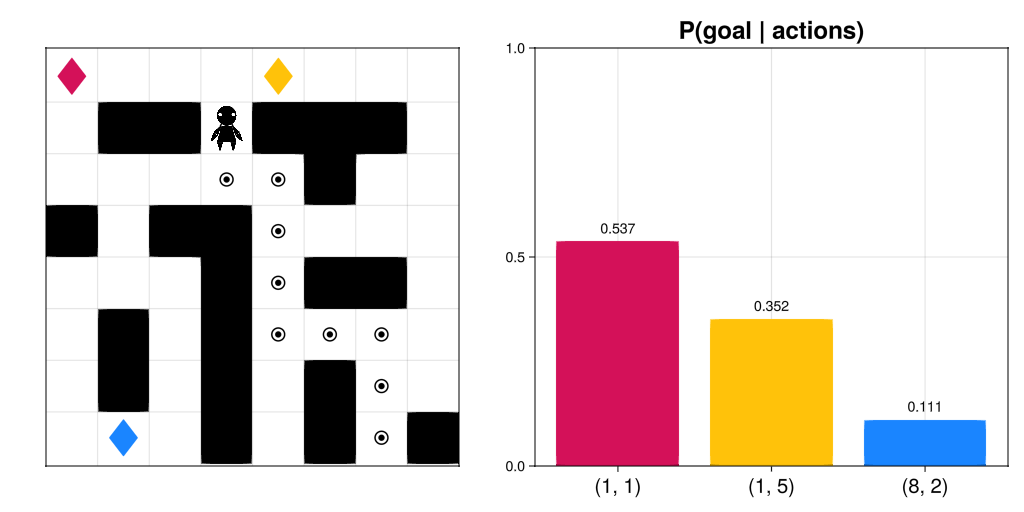

In [ ]:
"Plots bar chart of goal probabilities to an existing axis."
function plot_goal_probs!(ax, goal_labels, goal_probs,
                          goal_colors = GOAL_COLORS[1:length(goal_locs)])
    n_goals = length(goal_labels)
    barplot!(ax, 1:n_goals, goal_probs, color=goal_colors,
             bar_labels = :y, label_formatter = s -> @sprintf("%.3f", s))
    ylims!(ax, 0.0, 1.0)
    ax.xticks = (1:n_goals, [string(g) for g in goal_labels])
    ax.xticklabelsize = 20
    return ax
end

# Render trace and add new axis with goal probabilities
figure = render_trace(obs_trace, size=(1024, 512))
ax = Axis(figure[1, 2], title = "P(goal | actions)", titlesize = 24)
goal_probs = exp.(log_posterior_probs)
plot_goal_probs!(ax, goal_locs, goal_probs)
display(figure);

The inferred goal probabilities here make intuitive sense. The agent appears to
be heading towards either the red goal at (1, 1) or the yellow goal at (5, 1).
However, the yellow goal is slightly less likely, since there is another path
the agent could have taken to the right to reach the yellow goal. In contrast,
most of the observed actions are part of *all* optimal paths from the start to
the red goal. Finally, the fact that the agent moved up at the final step
indicates that the blue goal at (8, 2) is unlikely.

Recall that an important parameter in our Boltzmann-rational agent model is the
rationality coefficient $\beta$ (`beta`), which controls how optimal or noisy
we assume the agent to be. Let's see what happens to our goal inferences when
we compute them with different values of $\beta$:

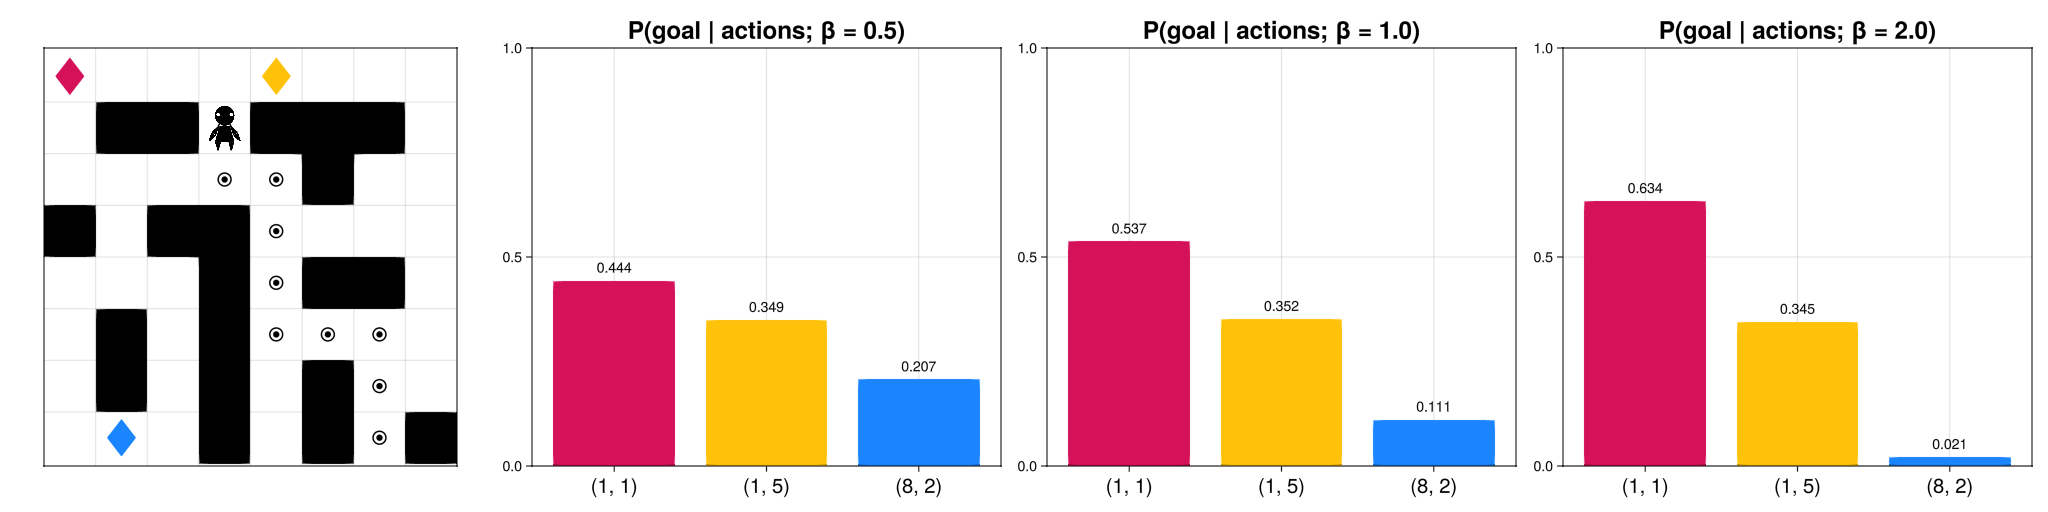

In [ ]:
# Render observed actions
figure = render_trace(obs_trace, size=(512*4, 512))

# Iterate over different values of beta and add plots
betas = [0.5, 1.0, 2.0]
for (i, beta) in enumerate(betas)
    # Run enumerative inference with current beta
    model_args = (T, grid, init_loc, goal_locs, beta)
    traces, log_posterior_probs, lml =
        enumerative_inference(gridworld_agent_model, model_args,
                              observations, choice_iter)
    # Add axis and bar chart of goal probabilities
    ax = Axis(figure[1, i+1], titlesize = 24,
              title = @sprintf("P(goal | actions; β = %.1f)", beta))
    goal_probs = exp.(log_posterior_probs)
    plot_goal_probs!(ax, goal_locs, goal_probs)
end
display(figure);

As the figure above shows, lower values of $\beta$ result in more graded
inferences, whereas higher values of $\beta$ result in sharper inferences.
This is because suboptimal trajectories to a particular goal have a much lower
likelihood when $\beta$ is high.

**Question**: Which value of $\beta$ leads to goal inferences that best
correspond with your own intuitive inferences? Now go back and use that value
of $\beta$ to simulate forward predictions of thhe agent's actions. Does the
$\beta$ that best capture your goal inferences also capture your intuitions
about how an agent acts over time?

### Understanding enumerative inference

Let's take a moment to understand how enumerative inference actually works in
Gen.jl, since this is useful for appreciating how it differs from the more
efficient algorithms we'll use later. Under-the-hood, enumerative inference
works as follows:
- Use `Gen.generate` method to generate traces consistent with both the
  observations and each possible latent choice.
- Call `Gen.get_score` to compute the log joint probability of each trace.
  This gives us the (log.) numerator of Bayes' rule for each latent choice.
- Summing the probabilities of each trace to get the denominator of Bayes' rule,
  and then dividing to get the posterior probability of each latent choice.

Here's how that looks in code for our agent model:

In [ ]:
# Specify model arguments and latent choices to enumerate over
model_args = (T, grid, init_loc, goal_locs, beta)
latent_choices = [choicemap((:goal, g)) for g in goal_locs]

# Iterate over traces and record joint probabilities
traces = []
log_joint_probs = Float64[]
for choices in latent_choices
    # Combine observation constraints (a_{1:T}) with latent choice (g)
    constraints = merge(observations, choices)
    # Generate trace constrained to current latent choice and observations
    trace, log_weight =
        Gen.generate(gridworld_agent_model, model_args, constraints)
    # Compute log joint probability (= log P(g, a_{1:T}, s_{1:T})) of the trace
    log_joint_prob = Gen.get_score(trace)
    # (Note: We could also use `log_weight` directly, w/o calling `get_score`)
    push!(traces, trace)
    push!(log_joint_probs, log_joint_prob)
end

# Compute log. denominator of Bayes' rule (= log P(a_{1:T}, s_{1:T}))
log_total_prob = logsumexp(log_joint_probs)
# Compute log. posterior probabilities (= log P(g | a_{1:T}, s_{1:T}))
log_posterior_probs = log_joint_probs .- log_total_prob

# Display probability of each latent choice
for (trace, log_p) in zip(traces, log_posterior_probs)
    println("goal = ", trace[:goal], "\t",
            "P(goal = $(trace[:goal])) = ", @sprintf("%.3f", exp(log_p)))
end

# Display log marginal likelihood of observations (= log P(a_{1:T}, s_{1:T}))
println("log P(obs) = ", @sprintf("%.3f", log_total_prob))

goal = (1, 1)	P(goal = (1, 1)) = 0.537
goal = (1, 5)	P(goal = (1, 5)) = 0.352
goal = (8, 2)	P(goal = (8, 2)) = 0.111
log P(obs) = -4.906


We see that our manual implementation of enumerative inference gives the same
results as the `enumerative_inference` function provided by Gen.jl.

As the implementation above makes clear, enumerative inference requires a
for-loop over *every* possible value of a latent variable. In other words, for
inference over discrete latent variables, enumerative inference is an *exact*
algorithm, since it computes Bayes' rule exactly. This is fine for small
hypothesis spaces, but scales poorly as the number of possible values or
latent variables increases. We'll see later on how to scale more efficiently
by turning to approximate, *sampling-based* inference algorithms.

Another limitation of enumerative inference — at least as we implemented it
above — is that we need to rerun the whole algorithm every time we receive
a new observation. This makes it inefficient for online goal inference.
In the next section, we'll see how to avoid this problem via *incremental
computation*.

## Online inverse planning via incremental computation

In many scenarios, we want to infer an agent's goal (and other mental states)
from a stream of incoming observations, updating a posterior distribution over
the agent's goal as we receive them. For example, this is important for
collaborative robots or AI assistants that have to interact with a user in
real-time. Such systems should continually update their inferences in order to
guide their actions.

A naive way to achieve online goal inference would be to run an inference
algorithm on the entire set of observations each time a new observation arrives.
Let's try this with enumerative inference and measure the runtime:

In [ ]:
# Construct a series of 20 actions to the blue goal
actions = [
    (-1, 0), (-1, 0), (0, 1), # Up twice then right
    (-1, 0), (-1, 0), # Up twice
    (0, -1), (0, -1), (0, -1), (-1, 0), # Left thrice then up
    (0, -1), (0, -1), (0, -1), # Left thrice
    (1, 0), (1, 0), (0, 1), # Down twice then right
    (1, 0), (1, 0), (1, 0), (0, -1), # Down thrice then left
    (0, 0) # Stay in place
]

# Allocate buffers to store runtime and goal probabilities
T = length(actions)
n_trials = 20
runtimes_enum = zeros(T)
goal_probs = zeros(length(goal_locs), T)

# Run inference for multiple trials to reduce runtime variance
choice_iter = choice_vol_grid((:goal, goal_locs))
GC.gc() # Force garbage collection to reduce runtime variance
for i_trial in 1:n_trials
    observations = choicemap()
    # Iterate over timesteps
    for (t, act) in enumerate(actions)
        # Add current action to observation choicemap
        observations[(:act, t)] = act
        # Run enumerative inference given all actions observed so far
        model_args = (t, grid, init_loc, goal_locs, beta)
        stats = @timed begin
            traces, log_posterior_probs, lml =
                enumerative_inference(gridworld_agent_model, model_args,
                                    observations, choice_iter)
        end
        # Record runtime and goal probabilities
        runtimes_enum[t] += stats.time
        goal_probs[:, t] += exp.(log_posterior_probs)
    end
end
# Average over trials
runtimes_enum ./= n_trials;
goal_probs ./= n_trials;

Now let's plot both the goal probabilities over time, and the runtime of the
algorithm for each step.

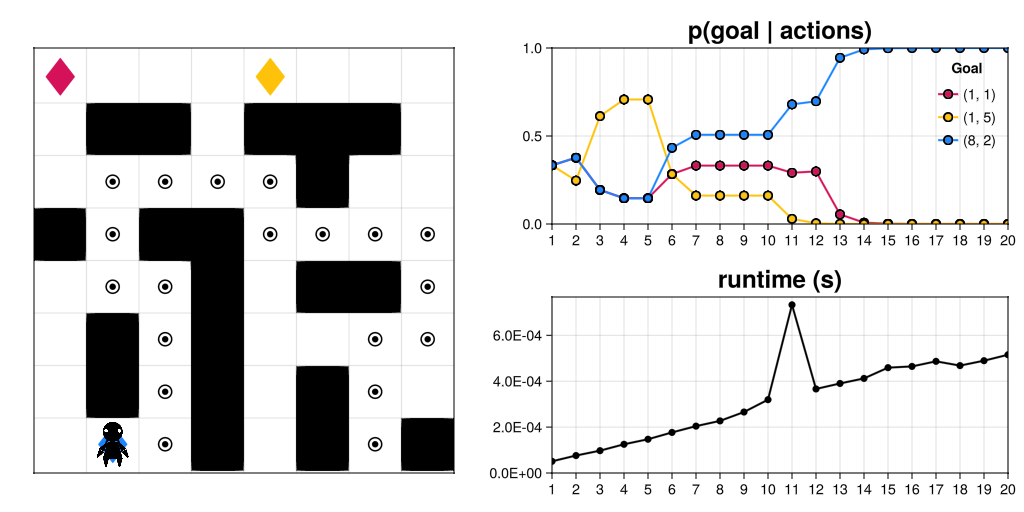

In [ ]:
# Render observed actions
obs_trace = Gen.generate(gridworld_agent_model, model_args, observations)[1]
figure = render_trace(obs_trace; size = (1024, 512))

# Plot goal probabilities over time
layout = GridLayout(figure[1, 2])
ax = Axis(layout[1, 1], titlesize = 24, title = "p(goal | actions)",
          limits = (1, T, 0, 1), xticks = 1:T)
series!(ax, 1:T, goal_probs, color = GOAL_COLORS[1:length(goal_locs)],
        strokewidth = 2.0, markercolor = GOAL_COLORS[1:length(goal_locs)],
        labels = string.(goal_locs))
axislegend(ax, "Goal", position = :rt, framevisible = false)

# Plot runtimes for each timestep
ax = Axis(layout[2, 1], titlesize = 24, title = "runtime (s)",
          limits = (1, T, 0, nothing), xticks = 1:T,
          ytickformat = ys -> [@sprintf("%.1E", y) for y in ys])
series!(ax, 1:T, runtimes_enum', markersize = 10.0, solid_color=:black)
display(figure);

In the top-right plot, we see that the posterior distribution over goals evolves
in a reasonable manner as more actions are observed. When the agent turns right
at `t = 3`, the probability of the yellow goal increases significantly. But once
the agent turns left again at `t = 6`, the yellow goal drops in probability.

As for the bottom-right plot, we can see that while the runtime of inference
is low (due to the simplicity of our gridworld environment), it increases more
or less linearly over time. The cumulative runtime of all steps is thus
*quadratic* in the number of observations. This is because each time we observe
a new action, we are re-evaluating the likelihood of *all* actions observed so
far, which requires recomputing the Q-values via planning for all steps.

While a quadratic runtime for online goal inference is acceptable for small
environments like the above, in more complex environments where planning is
harder, this can lead to significant runtime costs. Ideally then, we would like
to reuse our previous computations, and only compute the likelihood of the most
recent action when it is observed. We'll address this by using *incremental
computation* in the following ways:

1. Rewriting our agent model probabilistic program using Gen's `Unfold`
   combinator, enabling *incremental simulation* of our model using the
   `Gen.update` function.
2. Performing inference via a *Bayesian filtering* algorithm instead of
   `enumerative_inference`, which allows us to update our inferences
   step-by-step instead of re-running inference from scratch.
3. Further accelerating inference with an *incremental planning* algorithm,
   instead of rerunning Dijkstra's algorithm to compute Q-values at every step.

### Incremental model simulation with the `Unfold` combinator

Gen.jl provides the `Unfold` combinator, which allows us to replace a for-loop
in a probabilistic program with a subroutine that can be incrementally simulated
when the number of timesteps is increased (or decreased). To use the `Unfold`
combinator we'll write a *kernel function* called `agent_step` that simulates
just one timestep of the agent and environment (replacing the body of the
original for-loop). We'll then apply the `Unfold` combinator to our kernel to
construct a new probabilistic program (`agent_unfold = Unfold(agent_step)`), and
call `agent_unfold` as a subroutine in our full agent model:

In [ ]:
"Kernel function for one step of the gridworld agent model."
@gen function agent_step(t, model_state, grid, goal, beta)
    loc = model_state.loc
    # Compute Q-values and Boltzmann action probabilities
    actions, q_values = compute_q_values(grid, loc, goal)
    act_probs = softmax(beta .* q_values)
    # Sample action according to Boltzmann policy
    act = {:act} ~ labeled_categorical(actions, act_probs)
    # Update location following environment dynamics
    next_loc = gridworld_env_step(grid, loc, act)
    # Return new state containing both location and action
    next_model_state = (loc=next_loc, act=act)
    return next_model_state
end

# Apply Unfold combinator, returning a new generative function
agent_unfold = Gen.Unfold(agent_step)

"Agent model using the Unfold combinator for incremental simulation."
@gen (static) function unfold_agent_model(T, grid, init_loc, goal_locs, beta)
    # Sample goal from uniform goal prior
    goal = {:goal} ~ labeled_uniform(goal_locs)
    # Initial state contains location and a dummy action
    init_state = NamedTuple{(:loc, :act)}((init_loc, (0, 0)))
    # Simulate agent and environment for T steps
    model_states = {:steps} ~ agent_unfold(T, init_state, grid, goal, beta)
    # Return goal and history of locations and actions
    return goal, model_states
end;

Note the `(static)` annotation in front of `unfold_agent_model`, which declares
it as a [static generative function](https://www.gen.dev/docs/dev/ref/modeling/sml/).
This is currently required by Gen.jl to support incremental computation.

By rewriting our model with the `Unfold` combinator, we can incrementally
simulate our model using another of Gen's interface functions, `Gen.update`.
Starting with a trace initialized with `T=0`, we'll repeatedly apply
`Gen.update` to update the arguments passed to model:

In [ ]:
# Start with T=0 (no actions taken yet)
fixed_args = (grid, init_loc, goal_locs, beta)
init_args = (0, fixed_args...)
goal_constraint = choicemap((:goal, (1, 1)))
trace, _ = Gen.generate(unfold_agent_model, init_args, goal_constraint)
println("Initial trace at T=0:")
show(stdout, "text/plain", get_choices(trace))

# Incrementally extend the trace for T=1, 2, 3, ...
for T in 1:20
    new_args = # Update the timestep argument
        (T, fixed_args...)
    argdiffs = # Inform Gen.update that no other arguments have changed
        (UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
    trace, _, _, _ = # Update the previous trace to get a new trace
        Gen.update(trace, new_args, argdiffs, EmptyChoiceMap())
end
println("\n", "After extending to T=20:")
show(stdout, "text/plain", get_choices(trace))

Initial trace at T=0:
│
├── :goal : (1, 1)
│
└── :steps

After extending to T=20:
│
├── :goal : (1, 1)
│
└── :steps
    │
    ├── 1
    │   │
    │   └── :act : (0, 0)
    │
    ├── 2
    │   │
    │   └── :act : (0, 0)
    │
    ├── 3
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 4
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 5
    │   │
    │   └── :act : (0, -1)
    │
    ├── 6
    │   │
    │   └── :act : (0, 1)
    │
    ├── 7
    │   │
    │   └── :act : (0, 0)
    │
    ├── 8
    │   │
    │   └── :act : (0, -1)
    │
    ├── 9
    │   │
    │   └── :act : (0, 0)
    │
    ├── 10
    │   │
    │   └── :act : (0, -1)
    │
    ├── 11
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 12
    │   │
    │   └── :act : (0, 0)
    │
    ├── 13
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 14
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 15
    │   │
    │   └── :act : (0, -1)
    │
    ├── 16
    │   │
    │   └── :act : (-1, 0)
    │
    ├── 17
    │   │
    │   

Compared to our original model, the Unfold-based model has a slightly different
address structure for its random choices: All addresses for the action variables
are now nested under the address `:steps`, such that action $a_t$ has the
address `:steps => t => :act`.

Now let's record the runtime, averaging across multiple trials:

In [ ]:
# Compute average runtime across multiple trials
runtimes_unfold = zeros(T)
GC.gc() # Force garbage collection to reduce runtime variance
for trial in 1:n_trials
    # Generate initial trace of our Unfold model
    trace, _ = Gen.generate(unfold_agent_model, init_args, goal_constraint)
    # Incrementally extend the trace for T=1, 2, 3, ...
    for T in 1:20
        new_args = # Update the timestep argument
            (T, fixed_args...)
        argdiffs = # Inform Gen.update that no other arguments have changed
            (UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
        stats = @timed begin
            trace, _, _, _ = # Update the previous trace to get a new trace
                Gen.update(trace, new_args, argdiffs, EmptyChoiceMap())
        end
        runtimes_unfold[T] += stats.time
    end
end
runtimes_unfold ./= n_trials;

If we plot the runtime of each update, we'll see that it is more or less
constant (or even decreasing) across steps. This is because `Gen.update` only
simulates the model for the most recent step when `T` is incremented.

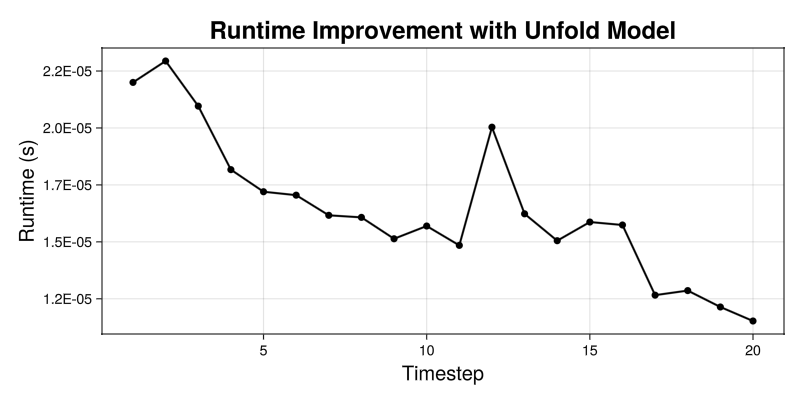

In [ ]:
figure = Figure(size=(800, 400))
ax = Axis(figure[1, 1], title="Runtime Improvement with Unfold Model",
          xlabel="Timestep", ylabel="Runtime (s)", xlabelsize=20, ylabelsize=20,
          ytickformat = ys -> [@sprintf("%.1E", y) for y in ys], titlesize=24)
series!(ax, 1:20, runtimes_unfold', labels=["Unfold Model"],
        linewidth=2, markersize=10, solid_color=:black)
display(figure);

In contrast, incremental computation is not supported by our original model,
so `Gen.update` still has the rerun the entire model from `t=0` each time `T` is
incremented. This results in a linearly increasing runtime:

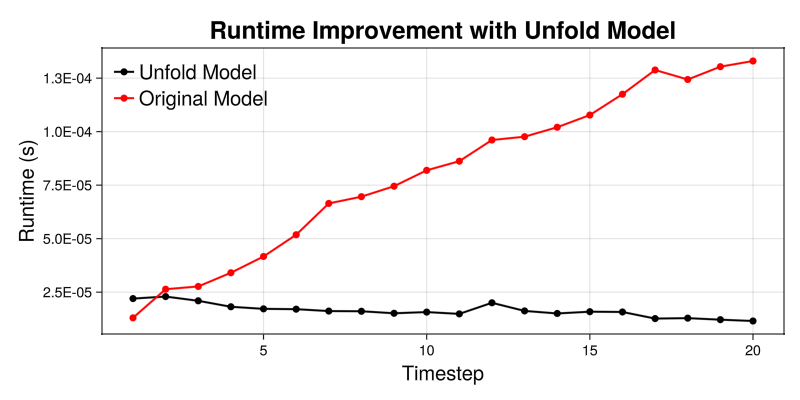

In [ ]:
# Compute average runtime across multiple trials
GC.gc() # Force garbage collection to reduce runtime variance
runtimes_original = zeros(T)
for trial in 0:n_trials
    # Generate initial trace of our original model
    trace, _ = Gen.generate(gridworld_agent_model, init_args, goal_constraint)
    # Incrementally extend the trace for T=1, 2, 3, ...
    for T in 1:20
        new_args = # Update the timestep argument
            (T, fixed_args...)
        argdiffs = # Inform Gen.update that no other arguments have changed
            (UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
        stats = @timed begin
            trace, _, _, _ = # Update the previous trace to get a new trace
                Gen.update(trace, new_args, argdiffs, EmptyChoiceMap())
        end
        if trial > 0 # Skip 0th trial to avoid counting compilation time
            runtimes_original[T] += stats.time # Record runtime
        end
    end
end
runtimes_original ./= n_trials;

# Add runtimes for original model to plot
series!(ax, 1:20, runtimes_original', labels=["Original Model"],
        linewidth=2, markersize=10, solid_color=:red)
axislegend(ax, position=:lt, framevisible=false, labelsize=20)
display(figure);

As we can see, while the runtime of the original model is similar for the first
few timesteps, it grows to be many times larger.

### Incremental goal inference via Bayesian filtering

Now that we have a model that can be incrementally simulated, we can implement
an inference algorithm that incrementally updates posterior beliefs about the
agent's goal as new actions are observed. This is known as *Bayesian filtering*
or *sequential Bayesian inference*. Instead of recomputing the full posterior
from scratch each time we observe a new action $a_{t}$, we can update our
posterior incrementally using Bayes' rule:

$$P(g | a_{1:t}) \propto P(g | a_{1:t-1}) P(a_{t} | g, a_{1:t-1}) $$

where $P(g | a_{1:t-1})$ is our posterior belief after observing the first $t-1$
actions, and $P(a_{t} | g, a_{1:t-1})$ is the likelihood of the new action
given the goal and previous actions.

To implement a Bayesian filter, we'll first define a `FilterState` struct that
maintains traces for each possible latent value (in our case, the agent's goal)
along with their associated weights (unnormalized posterior probabilities).

In [ ]:
"State for Bayesian filtering, storing traces and weights for each hypothesis."
struct FilterState
    traces::Vector{Trace}
    log_weights::Vector{Float64}
end;

Initialization of our Bayesian filter works similarly to enumerative inference.
Given an iterator over all possible latent values, we create a trace constrained
to each latent choice and any initial observations with `Gen.generate`:

In [ ]:
"Initialize Bayesian filter with uniform prior over goals."
function bayes_filter_init(model, model_args, choice_iter,
                           obs_init = EmptyChoiceMap())
    # Allocate buffers
    traces = Vector{Trace}(undef, length(choice_iter))
    log_weights = Vector{Float64}(undef, length(choice_iter))
    # Create a trace for each possible latent choice
    for (i, choices) in enumerate(choice_iter)
        constraints = merge(choices, obs_init)
        traces[i], log_weights[i] = Gen.generate(model, model_args, constraints)
    end
    return FilterState(traces, log_weights)
end;

As with `enumerative_inference`, it is the user's responsibility to ensure that
all latent values are enumerated over by `choice_iter`, and that  together with
`init_obs`, each set of latent `choices` results in a fully constrained
initial trace.

Now we'll implement the filter update. Given a new observation provided as a
choicemap `obs_new`, we extend each trace using `Gen.update`, which is called
with the both the new timestep and the new observation as arguments:

In [ ]:
"Update Bayesian filter with new timestep and observation."
function bayes_filter_step!(filter_state::FilterState,
                            t_new::Int, obs_new::ChoiceMap)
    # Update model arguments (assume first argument is timestep)
    old_args = Gen.get_args(filter_state.traces[1])
    new_args = (t_new, old_args[2:end]...)
    argdiffs = (UnknownChange(), map(x -> NoChange(), old_args[2:end])...)

    # Update each trace with the new timestep and observation
    for i in 1:length(filter_state.traces)
        # Update trace to new timestep and incorporate new observation
        trace, incremental_weight, _, _ = Gen.update(
            filter_state.traces[i], new_args, argdiffs, obs_new
        )
        # Update stored trace and add log-likelihood of new observation
        filter_state.traces[i] = trace
        filter_state.log_weights[i] += incremental_weight
    end
    return filter_state
end;

Notice that in addition to returning an updated trace, `Gen.update` also returns
the *incremental log-probability* (a.k.a. incremental weight) of the new trace
relative to the old trace. For our model, this incremental weight is exactly
equal to $\log P(a_{t} | g, a_{1:t-1})$, the log-likelihood of the most recent
action, since $a_{t}$ is the only random variable introduced when we move to
timestep $t$.  As such, we can update our (unnormalized) posterior probabilities
by incrementing the `log_weights` stored in our `FilterState`.

Now let's test our Bayes filter on the same sequence of actions we used to
study the runtime of enumerative inference.

In [ ]:
# Allocate buffers to store runtime and goal probabilities
T = length(actions)
n_trials = 20
runtimes_bfilter = zeros(T)
goal_probs = zeros(length(goal_locs), T)

# Run inference for multiple trials to reduce runtime variance
GC.gc() # Force garbage collection to reduce runtime variance
init_args = (0, grid, init_loc, goal_locs, beta)
choice_iter = (choicemap((:goal, g)) for g in goal_locs)
for trial in 0:n_trials
    # Initialize Bayes filter
    filter_state = bayes_filter_init(unfold_agent_model, init_args, choice_iter)
    # Process each action incrementally
    for (t, act) in enumerate(actions)
        # Create observation for this timestep
        obs_t = choicemap((:steps => t => :act, act))
        # Update Bayes filter and measure runtime
        stats = @timed begin
            bayes_filter_step!(filter_state, t, obs_t)
        end
        # Record runtime and goal probability
        if trial > 0 # Skip 0th trial to avoid counting compilation time
            runtimes_bfilter[t] += stats.time
            goal_probs[:, t] += softmax(filter_state.log_weights)
        end
    end
end
# Average over trials
runtimes_bfilter ./= n_trials;
goal_probs ./= n_trials;

Plotting the inferred goal probabilities and runtimes, we should see exactly
the same inferences as produced by enumerative inference, but now without
the linearly increasing runtime per step.

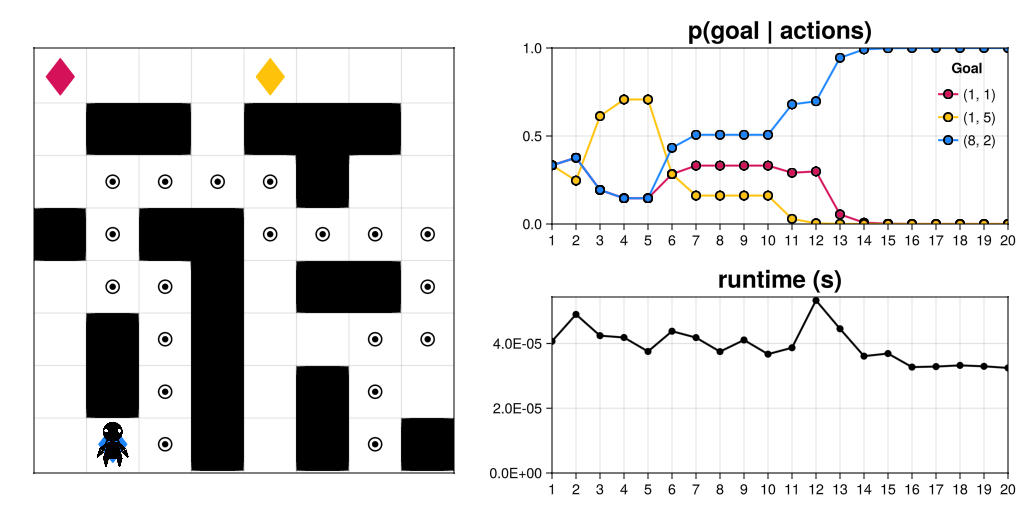

In [ ]:
# Render observed actions
figure = render_trace(obs_trace; size = (1024, 512))

# Plot goal probabilities over time
layout = GridLayout(figure[1, 2])
ax = Axis(layout[1, 1], titlesize = 24, title = "p(goal | actions)",
          limits = (1, T, 0, 1), xticks = 1:T)
series!(ax, 1:T, goal_probs, color = GOAL_COLORS[1:length(goal_locs)],
        strokewidth = 2.0, markercolor = GOAL_COLORS[1:length(goal_locs)],
        labels = string.(goal_locs))
axislegend(ax, "Goal", position = :rt, framevisible = false)

# Plot runtimes for each timestep
ax = Axis(layout[2, 1], titlesize = 24, title = "runtime (s)",
          limits = (1, T, 0, nothing), xticks = 1:T,
          ytickformat = ys -> [@sprintf("%.1E", y) for y in ys])
series!(ax, 1:T, runtimes_bfilter', markersize = 10.0, solid_color=:black,
        labels = ["Bayes Filter w. Unfold Model"])
display(figure);

If we add the runtimes for enumerative inference to the same plot, we see
a marked difference compared to Bayesian filtering:

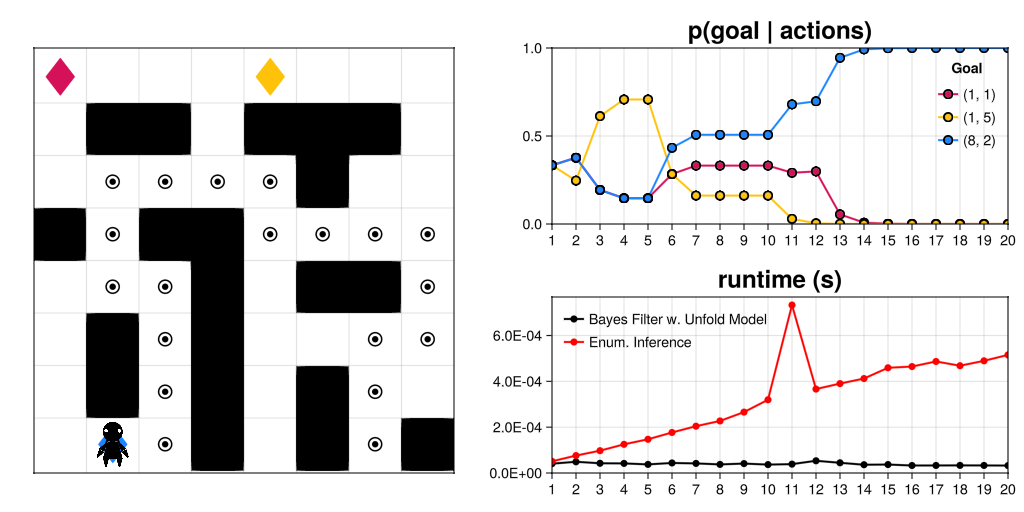

In [ ]:
series!(ax, 1:T, runtimes_enum', markersize = 10.0, solid_color=:red,
        labels = ["Enum. Inference"])
axislegend(ax, position = :lt, framevisible = false)
display(figure);

Through incremental computation, we have eliminated the unnecessary overhead
of re-simulating the model from scratch at each timestep. While there are other
ways we could have eliminated this overhead (e.g. implementing inference
manually instead of using Gen.jl), doing this with Gen.jl allows us to maintain
a clean separation between modeling and inference code, enabling future
revisions to our model without having to reimplement inference. We'll consider
one such revision in the next subsection.

### Incremental planning for faster computation of Q-values

While we have achieved incremental computation for model simulation and
inference, there is still one place where incremental computation can lead to
significant benefits: computing Q-values via planning. Currently, our
`compute_q_values` function runs Dijkstra's algorithm from scratch for each
action at every timestep. If we translate this approach to more complex domains,
we might use A* search or value iteration instead. But since optimal planning
can be very expensive in complex environments, running such algorithms at every
step can be quite costly.

**Question**: One potential way to avoid replanning at every step is to plan
entirely *in advance*, precomputing the Q-values of any action the agent might
take at all states. Then at each step, we just have to lookup the Q-values at
the current state for essentially no cost. Classical approaches to inverse
reinforcement learning and inverse optimal control often use this strategy, and
deep inverse RL approaches can be viewed as extending this idea, pre-training a
neural network that estimates Q-values in advance of goal inference. When is
this approach reasonable, and when might it struggle to scale?

Instead of replanning at every step, or exhaustive planning-in-advance, here
we'll take an intermediate approach known as *incremental planning*. The key
insight is that when the agent transitions from one state to another, the
planning solution we computed in the previous step can be reused to accelerate
planning in the current step.

There exist many planning algorithms that are called "incremental", "real-time",
or "anytime" because they reuse previous planning computations. Some examples
include:
- [fringe-retrieving A*](https://idm-lab.org/bib/abstracts/papers/aamas10b.pdf)
- [real-time heuristic search](https://link.springer.com/article/10.1007/s10458-008-9061-x),
- [real-time dynamic programming](https://www.sciencedirect.com/science/article/pii/000437029400011O),
- [MCTS with tree reuse](https://arxiv.org/abs/2407.03049))

In our case, we'll use an incremental version of Dijkstra's algorithm (similar
to step 1 of fringe-retrieving A*), which involves two changes:
1. Instead of running Dijkstra's forwards from the agent's current location to
   the goal, we run it backwards from the goal to the agent's current location
   (and all adjacent locations).
2. We store the distance-to-goal for each state that Dijkstra's algorithm
   has reached so far (allowing us to look up Q-values for states that have
   already been reached), and the queue of states that have yet to be visited
   (allowing us to continue the search instead of restarting from scratch).

To achieve the above, we'll first define a `DijkstraSolution` struct, which
stores both the distances-to-goal and the information needed to resume
Dijkstra's algorithm in the next step:

In [ ]:
"State for incremental Dijkstra's algorithm."
struct DijkstraSolution
    goal::Tuple{Int, Int}
    distances::Matrix{Float64}
    queue::Vector{Tuple{Float64, Tuple{Int, Int}}}
end

# Define initializer
function DijkstraSolution(goal, grid_size)
    # Initialize distances to Inf
    distances = fill(Inf, grid_size...)
    distances[goal...] = 0
    # Initialize search queue (FIFO is enough since action costs are equal)
    queue = [(0.0, goal)]
    return DijkstraSolution(goal, distances, queue)
end

# Define copy constructor
DijkstraSolution(sol::DijkstraSolution) =
    DijkstraSolution(sol.goal, copy(sol.distances), copy(sol.queue));

Now we implement the incremental version of Dijkstra's algorithm, which takes
an existing solution and continues searching until the target location(s) are
reached.

In [ ]:
"Incrementally extend Dijkstra's solution (single-target, mutating version)."
function dijkstra_step!(sol::DijkstraSolution, grid, target::Tuple{Int, Int})
    # Return existing solution if target is unreachable
    (!checkbounds(Bool, grid, target...) || grid[target...]) && return sol
    # Return existing solution if target has already been reached
    sol.distances[target...] < Inf && return sol
    # Run Dijkstra until search queue is empty
    while !isempty(sol.queue)
        dist, loc = popfirst!(sol.queue)
        # Terminate if target is reached
        if loc == target
            return sol
        end
        # Expand search in all directions around current location
        for d in ((-1, 0), (1, 0), (0, -1), (0, 1))
            next_loc = loc .+ d
            if checkbounds(Bool, grid, next_loc...) && !grid[next_loc...]
                alt = dist + 1
                if alt < sol.distances[next_loc...]
                    sol.distances[next_loc...] = alt
                    push!(sol.queue, (alt, next_loc))
                end
            end
        end
    end
    return sol
end

"Incrementally extend Dijkstra's solution (multi-target, mutating version)."
function dijkstra_step!(sol::DijkstraSolution, grid, targets)
    for target in targets
        dijkstra_step!(sol, grid, target)
    end
    return sol
end

"Incrementally extend Dijkstra's solution (non-mutating version)."
function dijkstra_step(sol::DijkstraSolution, grid, targets)
    return dijkstra_step!(DijkstraSolution(sol), grid, targets)
end;

Let's test that our incremental Dijkstra implementation produces the same
results as the original non-incremental version.

In [ ]:
# Test locations to compute shortest path distances for
test_targets = ((1, 1), (1, 5), (8, 2))
test_goal = (5, 3)

# Compute distances using original algorithm
original_distances =
    [shortest_path_length(grid, loc, test_goal) for loc in test_targets]

# Compute distances using incremental algorithm
sol = DijkstraSolution(test_goal, size(grid))
dijkstra_step!(sol, grid, test_targets[3:3]) # Run until we reach target 3
dijkstra_step!(sol, grid, test_targets[1:2]) # Run until we reach the rest
incremental_distances = [sol.distances[loc...] for loc in test_targets]

# Check that results match
println("Original distances: ", original_distances)
println("Incremental distances: ", incremental_distances)
println("Results match: ", all(original_distances ≈ incremental_distances))

Original distances: [6.0, 8.0, 4.0]
Incremental distances: [6.0, 8.0, 4.0]
Results match: true


Our incremental Dijkstra implementation matches the results of the original
version, as expected!

Now we can rewrite our agent model to use the incremental algorithm. Since the
state of the `Unfold` combinator needs to store both theenvironment state and
the Dijkstra solution, we'll use a NamedTuple to organize this information:

In [ ]:
"Kernel function using incremental planning for Q-value computation."
@gen function incremental_agent_step(t, model_state, grid, goal, beta)
    loc = model_state.loc
    # Make copy of previous solution (to be updated in-place)
    next_sol = DijkstraSolution(model_state.sol)
    # Compute Q-values for each action
    actions = ((0, 0), (-1, 0), (1, 0), (0, -1), (0, 1))
    q_values = zeros(length(actions))
    for (i, act) in enumerate(actions)
        next_loc = loc .+ act
        if checkbounds(Bool, grid, next_loc...) && !grid[next_loc...]
            # Extend Dijkstra solution to next location, if reachable
            next_sol = dijkstra_step!(next_sol, grid, next_loc)
            # Lookup value of next location, add action cost to get Q-value
            q_values[i] = -next_sol.distances[next_loc...] - 1
        else
            # Negative infinite Q-value if next location is unreachable
            q_values[i] = -Inf
        end
    end
    # Sample action according to Boltzmann policy
    act_probs = softmax(beta .* q_values)
    act = {:act} ~ labeled_categorical(actions, act_probs)
    # Update location following environment dynamics
    next_loc = gridworld_env_step(grid, loc, act)
    # Return new state with updated location and Dijkstra solution
    next_model_state = (loc=next_loc, act=act, sol=next_sol)
    return next_model_state
end

# Apply Unfold combinator
incremental_agent_unfold = Gen.Unfold(incremental_agent_step)

"Agent model using incremental planning for faster Q-value computation."
@gen (static) function incremental_agent_model(T, grid, init_loc, goal_locs, beta)
    # Sample goal from uniform goal prior
    goal = {:goal} ~ labeled_uniform(goal_locs)
    # Initialize Dijkstra solution for the chosen goal
    init_sol = DijkstraSolution(goal, size(grid))
    init_state = NamedTuple{(:loc, :act, :sol)}((init_loc, (0, 0), init_sol))
    # Simulate agent for T steps using incremental planning
    model_states =
        {:steps} ~ incremental_agent_unfold(T, init_state, grid, goal, beta)
    return goal, model_states
end;

Before comparing inference runtimes with and without incremental planning,
let's create a larger (16 x 16) grid for our tests, so that the costs of
repeated planning are more significant.

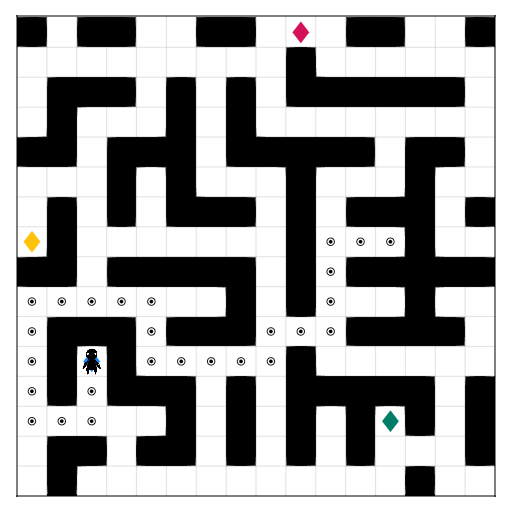

In [ ]:
"Parse grid from text representation."
function parse_grid(text::AbstractString)
    grid = map(l -> BitVector(c == 'X' for c in l), split(text, "\n"))
    return permutedims(reduce(hcat, grid))
end

# Specify arguments
grid_text = """
X.XX..XX...XX..X
.........X......
.XXX.X.X.XXXXXX.
.X...X.X........
XX.XXX.XXXXX.XX.
...X.X...X...X..
.X.X.XXX.X.XXX.X
.X.......X...X..
XX.XXXXX.X.XXXXX
.......X.X...X..
.XXX.XXX...XXXX.
.X.X.....X......
.X.XXX.X.XXXXX.X
.....X.X.X.X.X.X
.XX.XX.X.X.X...X
.X...........X.."""
grid = parse_grid(grid_text) # Parse grid from text maze
init_loc = (8, 13) # Initial location at row 7, column 13
goal_locs = ((1, 10), (8, 1), (12, 3), (14, 13)) # 4 possible goal locations
beta = 0.5 # Assume the agent is noisily rational

# Specify observed actions as a choicemap
actions = [
    (0, -1), (0, -1), # Left twice
    (1, 0), (1, 0), (1, 0), # Down thrice
    (0, -1), (0, -1), # Left twice
    (1, 0), # Down once
    (0, -1), (0, -1), (0, -1), (0, -1), # Left four times
    (-1, 0), (-1, 0), # Up twice
    (0, -1), (0, -1), (0, -1), (0, -1), # Left four times
    (1, 0), (1, 0), (1, 0), (1, 0), # Down four times
    (0, 1), (0, 1), # Right twice
    (-1, 0), (-1, 0), # Up twice
]
observations =
    choicemap([(:steps => t => :act, a) for (t, a) in enumerate(actions)]...)

# Generate trace with observed actions
T = length(actions)
model_args = (T, grid, init_loc, goal_locs, beta)
trace, _ = Gen.generate(incremental_agent_model, model_args, observations)

# Visualize trace
render_trace(trace)

Now let's run Bayesian filtering with both the incremental planning and
non-incremental planning models, recording the runtime and goal probabilities
for each timestep.

In [ ]:
# Allocate buffers to store runtime and goal probabilities
T = length(actions)
n_trials = 20
runtimes_unfold = zeros(T)
runtimes_incremental = zeros(T)
goal_probs_unfold = zeros(length(goal_locs), T)
goal_probs_incremental = zeros(length(goal_locs), T)

# Run inference for multiple trials to reduce runtime variance
GC.gc() # Force garbage collection to reduce runtime variance
init_args = (0, grid, init_loc, goal_locs, beta)
choice_iter = (choicemap((:goal, g)) for g in goal_locs)
for trial in 0:n_trials
    # Initialize Bayes filter with unfold agent model
    filter_state_unfold =
        bayes_filter_init(unfold_agent_model, init_args, choice_iter)
    # Initialize Bayes filter with incremental agent model
    filter_state_incremental =
        bayes_filter_init(incremental_agent_model, init_args, choice_iter)
    # Process each action incrementally
    for (t, act) in enumerate(actions)
        # Create observation for this timestep
        obs_t = choicemap((:steps => t => :act, act))
        # Update Bayes filter for unfold agent model and measure runtime
        stats_unfold = @timed begin
            bayes_filter_step!(filter_state_unfold, t, obs_t)
        end
        # Update Bayes filter for incremental agent model and measure runtime
        stats_incremental = @timed begin
            bayes_filter_step!(filter_state_incremental, t, obs_t)
        end
        # Record runtime and goal probability
        if trial > 0 # Skip 0th trial to avoid counting compilation time
            runtimes_unfold[t] += stats_unfold.time
            runtimes_incremental[t] += stats_incremental.time
            goal_probs_unfold[:, t] +=
                softmax(filter_state_unfold.log_weights)
            goal_probs_incremental[:, t] +=
                softmax(filter_state_incremental.log_weights)
        end
    end
end

# Average over trials
runtimes_unfold ./= n_trials;
runtimes_incremental ./= n_trials;
goal_probs_unfold ./= n_trials;
goal_probs_incremental ./= n_trials;

# Check that goal probabilities are (approximately) the same
println("Inference results match: ",
        all(isapprox.(goal_probs_unfold, goal_probs_incremental, atol=0.001)))

Inference results match: true


As expected, the inferred goal probabilities match regardless of whether
we're using incremental planning or non-incremental planning in our agent model.
Now let's compare their runtimes:

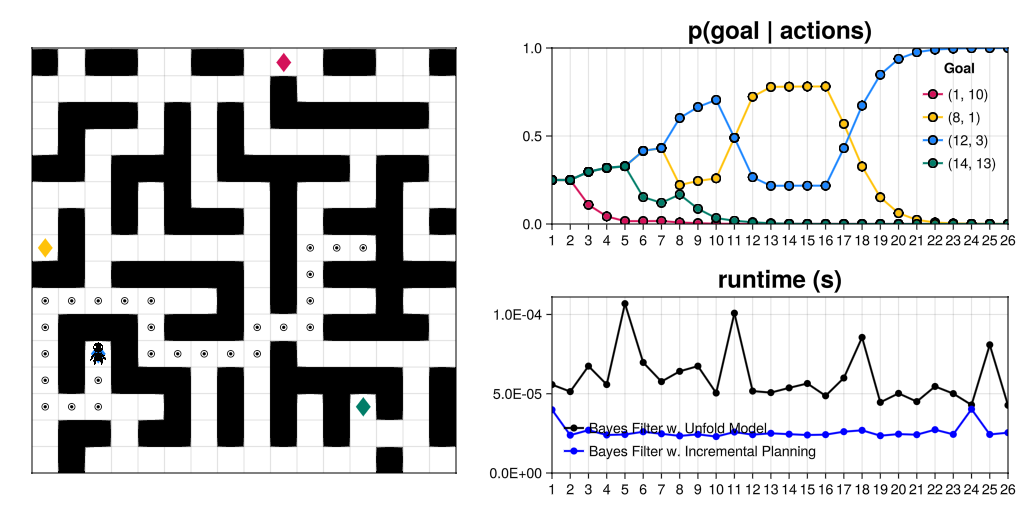

In [ ]:
# Render observed actions
obs_trace, _ = Gen.generate(incremental_agent_model, model_args, observations)
figure = render_trace(obs_trace; size = (1024, 512))

# Plot goal probabilities over time
goal_probs = goal_probs_incremental
layout = GridLayout(figure[1, 2])
ax = Axis(layout[1, 1], titlesize = 24, title = "p(goal | actions)",
          limits = (1, T, 0, 1), xticks = 1:T)
series!(ax, 1:T, goal_probs, color = GOAL_COLORS[1:length(goal_locs)],
        strokewidth = 2.0, markercolor = GOAL_COLORS[1:length(goal_locs)],
        labels = string.(goal_locs))
axislegend(ax, "Goal", position = :rt, framevisible = false)

# Plot runtimes for each timestep
ax = Axis(layout[2, 1], titlesize = 24, title = "runtime (s)",
          limits = (1, T, 0, nothing), xticks = 1:T,
          ytickformat = ys -> [@sprintf("%.1E", y) for y in ys])
series!(ax, 1:T, runtimes_unfold', markersize = 10.0, solid_color=:black,
        labels = ["Bayes Filter w. Unfold Model"])
series!(ax, 1:T, runtimes_incremental', markersize = 10.0, solid_color=:blue,
        labels = ["Bayes Filter w. Incremental Planning"])
axislegend(ax, position = :lb, framevisible = false)
display(figure);

As we can see, incremental planning provides additional computational savings
beyond what we achieved with the Unfold-based model alone. By avoiding redundant
recomputation of shortest paths, the incremental planning approach achieves
the best runtime performance while maintaining identical inference results.
As the planning problem becomes more complicated, the runtime savings of
incremental planning can be quite significant.

This demonstrates the power of incremental computation in probabilistic
programming: by rewriting our models to reuse previous computations, we can
achieve significant performance improvements without sacrificing the modularity
and clarity of our probabilistic programs.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*